# Evaluation of models on test data

In [2]:
import util
import plotting
import evaluation
import preprocessing

import numpy as np
import pandas as pd
from skimage.color import label2rgb
from skimage import filters, measure, segmentation

import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

from tqdm import tqdm
import tensorflow as tf

In [3]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## No preprocessing, different batch sizes

In [4]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [5]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'ref')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/model.h5

Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/ref_f8_c9_b32/model.h5

Loading H:/Santi/Models/ref_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/history

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/ref_f8_c9_b32/history

Loading H:/Santi/Models/ref_f8_c9_b256/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/frames_test

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/ref_f8_c9_b32/frames_test

Loading H:/Santi/Models/ref_f8_c9_b256/frames_test
Done.


In [6]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name])  

del output_data, labels, input_data

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: ref_f8_c9_b8


 25%|████████████████                                                | 1/4 [00:09<00:27,  9.21s/it]


Model: ref_f8_c9_b16


 50%|████████████████████████████████                                | 2/4 [00:16<00:15,  7.92s/it]


Model: ref_f8_c9_b32


 75%|████████████████████████████████████████████████                | 3/4 [00:23<00:07,  7.59s/it]


Model: ref_f8_c9_b256


100%|████████████████████████████████████████████████████████████████| 4/4 [00:30<00:00,  7.62s/it]


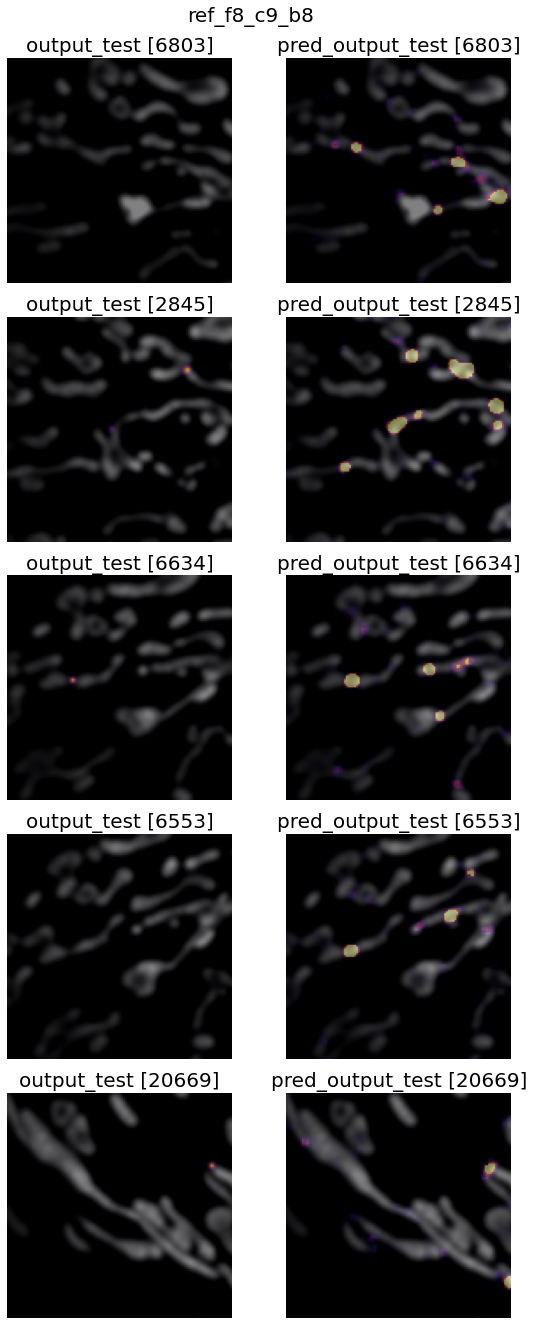

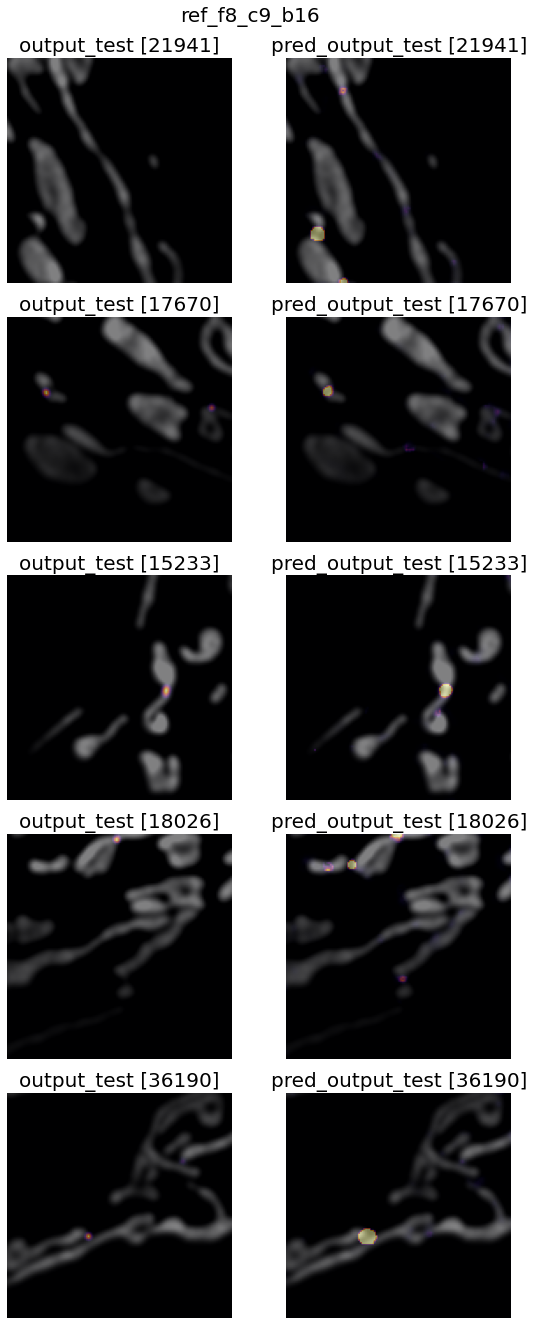

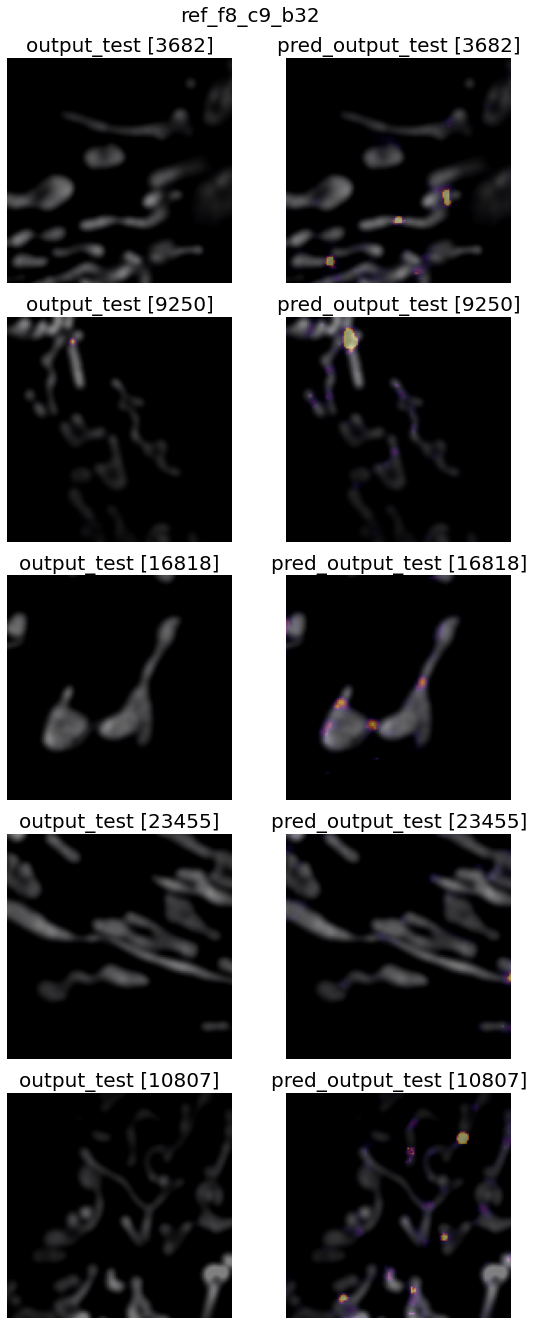

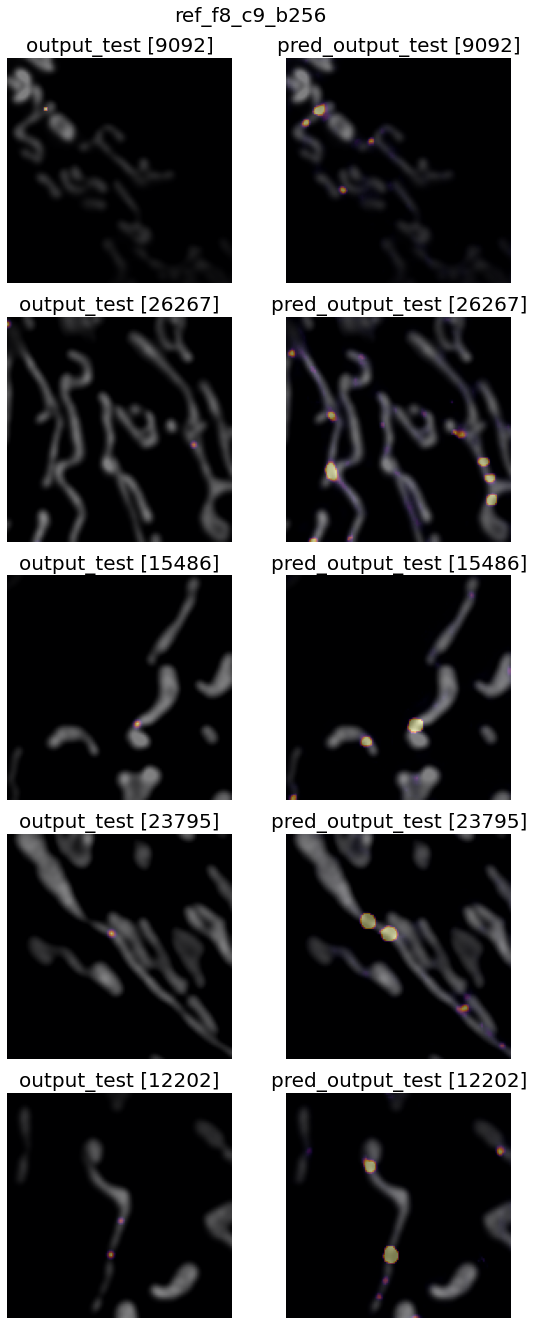

In [7]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [8]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

ref_f8_c9_b8: 0.76


100%|██████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.28it/s]
C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:110: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),


ref_f8_c9_b16: 0.76


100%|██████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


ref_f8_c9_b32: 0.75


100%|██████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


ref_f8_c9_b256: 0.76


100%|██████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.22it/s]


Saving H:/Santi/Models/ref_f8_c9_b8/metrics

Saving H:/Santi/Models/ref_f8_c9_b16/metrics

Saving H:/Santi/Models/ref_f8_c9_b32/metrics

Saving H:/Santi/Models/ref_f8_c9_b256/metrics
Done.


In [9]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(model), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/metrics

Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/ref_f8_c9_b32/metrics

Loading H:/Santi/Models/ref_f8_c9_b256/metrics
Done.


### All metrics

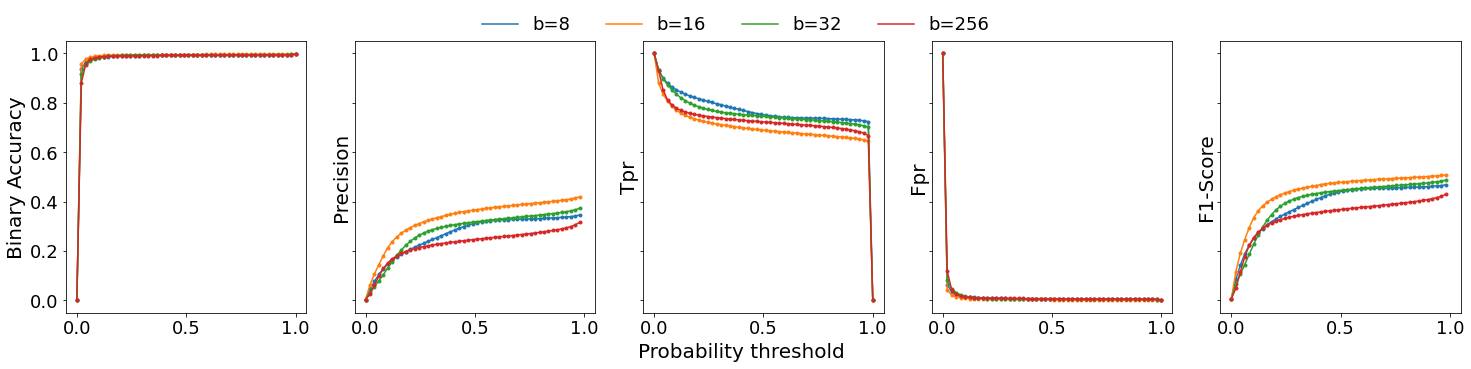

In [10]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name.title())
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)
plt.show()

### metricAtMaxThreshold

In [11]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

ref_f8_c9_b8  ref_f8_c9_b16  ref_f8_c9_b32  ref_f8_c9_b256
binary accuracy      0.994731       0.996018       0.995367        0.994197
precision            0.345865       0.419817       0.372975        0.316267
TPR                  0.723543       0.645070       0.700927        0.667311
FPR                  0.004397       0.002857       0.003707        0.004731
F1-score             0.468013       0.508620       0.486875        0.429144

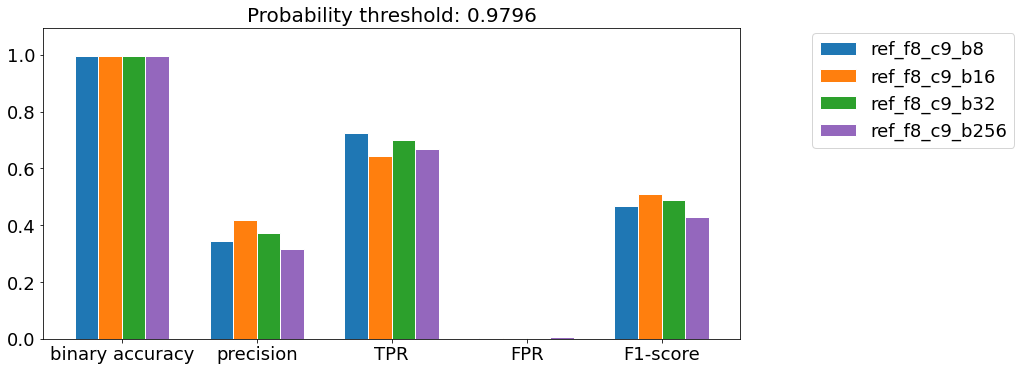

In [12]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'ref_f8_c9_b8': 0.003203017776076858, 'ref_f8_c9_b16': 0.0031948110219594595, 'ref_f8_c9_b32': 0.003136093552048142, 'ref_f8_c9_b256': 0.0032687130489864867}


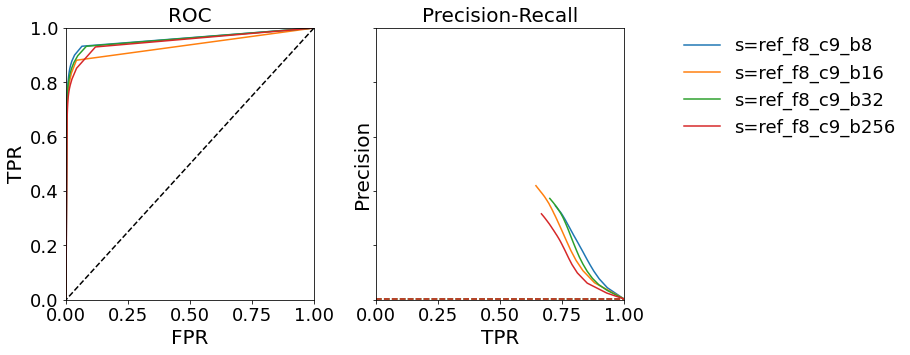

In [13]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

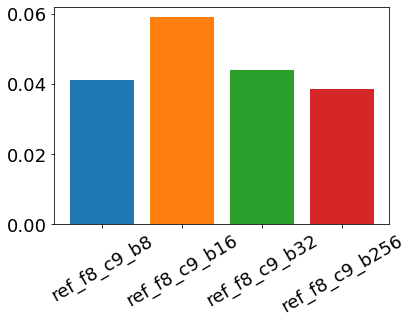

In [14]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

In [15]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats = fissionStats.T


Model name: ref_f8_c9_b8


100%|████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3103.11it/s]



Model name: ref_f8_c9_b16


100%|████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3044.32it/s]



Model name: ref_f8_c9_b32


100%|████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3072.17it/s]



Model name: ref_f8_c9_b256


100%|████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3014.53it/s]


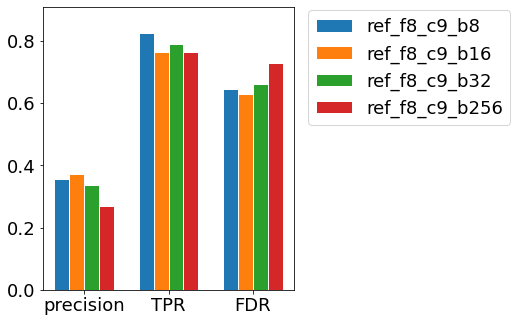

In [16]:
plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], color=colors)
plt.show()

## MitoProc, different batch sizes

In [15]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [16]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'mp')
folder_name = [model_name for model_name in folder_name if '_s' not in model_name]
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b32/model.h5

Loading H:/Santi/Models/mp_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/history

Loading H:/Santi/Models/mp_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b32/history

Loading H:/Santi/Models/mp_f8_c9_b256/history
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b32/frames_test

Loading H:/Santi/Models/mp_f8_c9_b256/frames_test
Done.


In [17]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name])  

del output_data, labels, input_data

  0%|                                                                                                                                                                         | 0/4 [00:00<?, ?it/s]


Model: mp_f8_c9_b8


 25%|████████████████████████████████████████▎                                                                                                                        | 1/4 [00:07<00:21,  7.08s/it]


Model: mp_f8_c9_b16


 50%|████████████████████████████████████████████████████████████████████████████████▌                                                                                | 2/4 [00:14<00:14,  7.11s/it]


Model: mp_f8_c9_b32


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3/4 [00:21<00:07,  7.19s/it]


Model: mp_f8_c9_b256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.14s/it]


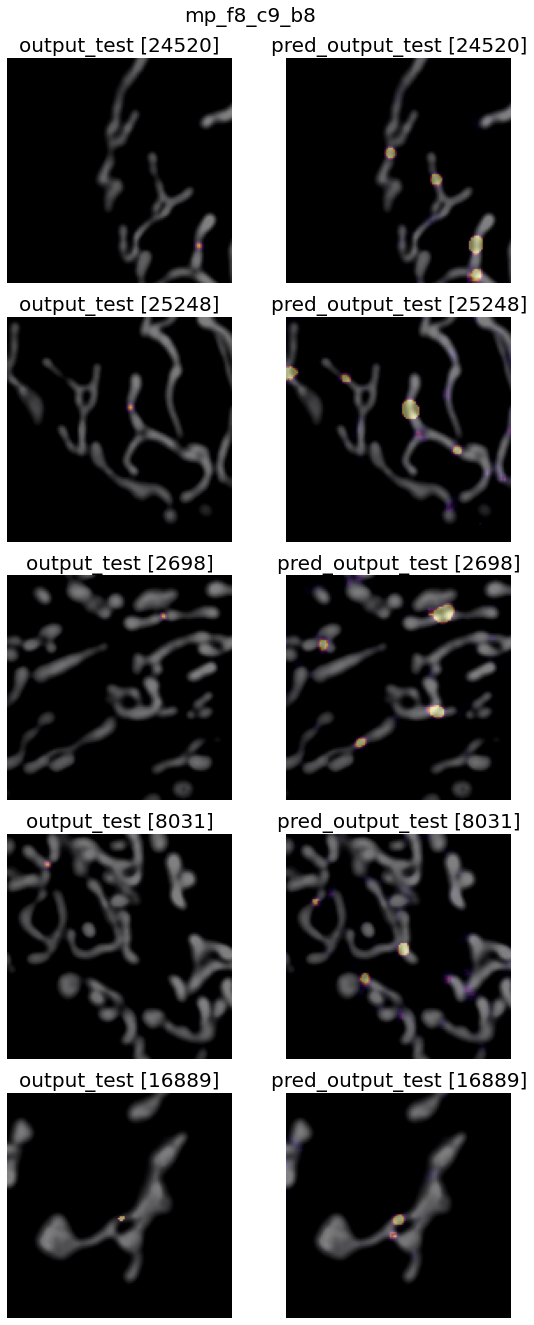

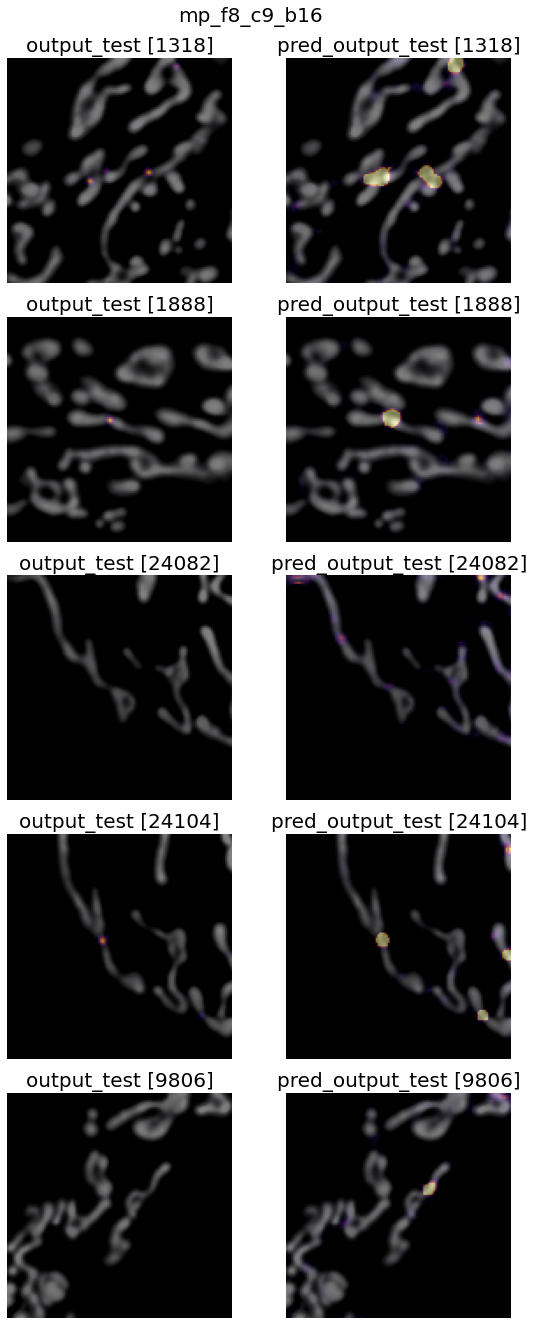

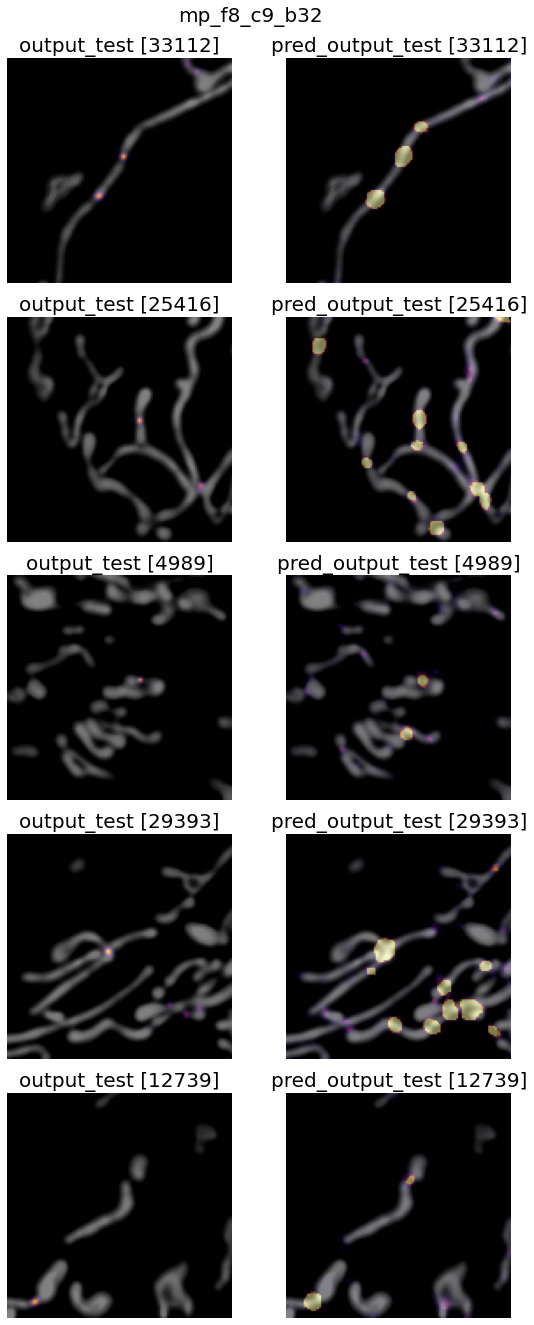

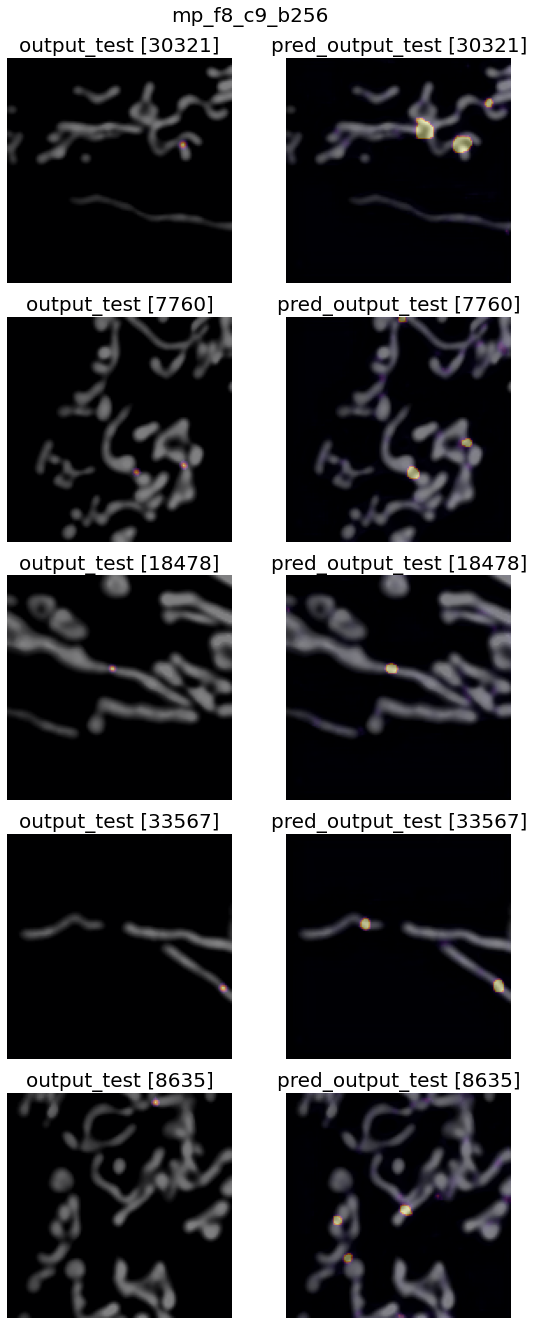

In [18]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [19]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b32/metrics

Loading H:/Santi/Models/mp_f8_c9_b256/metrics
Done.


### All metrics

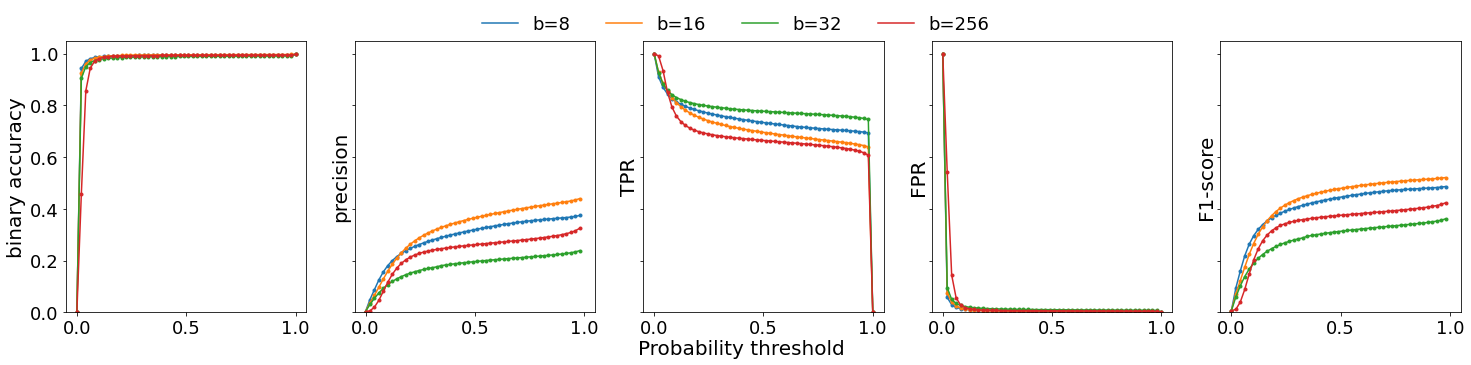

In [20]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0.01, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)

plt.show()

### metricAtMaxThreshold

In [21]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

mp_f8_c9_b8  mp_f8_c9_b16  mp_f8_c9_b32  mp_f8_c9_b256
binary accuracy     0.995174      0.996322      0.991400       0.994677
precision           0.374470      0.439567      0.238522       0.324960
TPR                 0.693245      0.639223      0.745263       0.607050
FPR                 0.003828      0.002557      0.007793       0.004072
F1-score            0.486271      0.520919      0.361383       0.423315

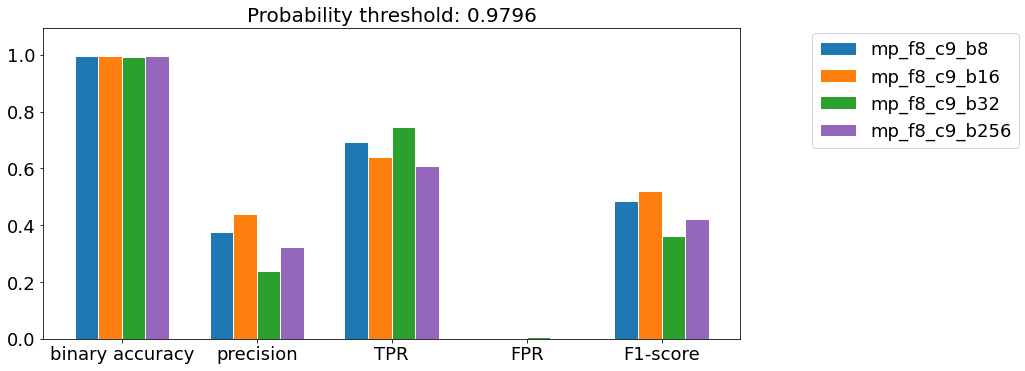

In [22]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'mp_f8_c9_b8': 0.0032943890545819258, 'mp_f8_c9_b16': 0.003128216717694257, 'mp_f8_c9_b32': 0.0032648447397592905, 'mp_f8_c9_b256': 0.003218532252956081}


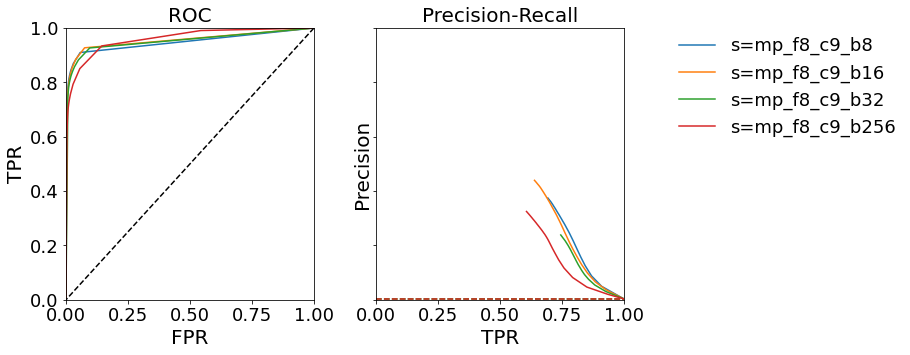

In [23]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

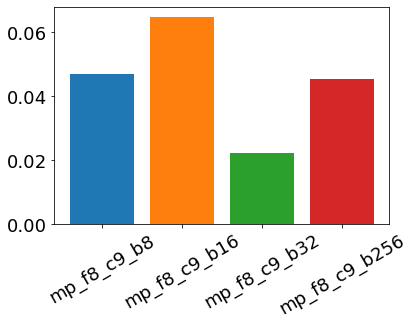

In [24]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

In [25]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats = fissionStats.T


Model name: mp_f8_c9_b8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3312.14it/s]



Model name: mp_f8_c9_b16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3382.80it/s]



Model name: mp_f8_c9_b32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3239.38it/s]



Model name: mp_f8_c9_b256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3266.15it/s]


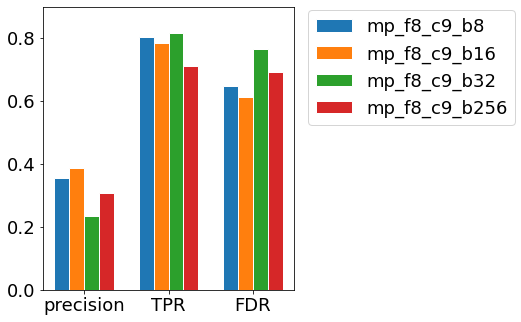

In [26]:
plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], color=colors)
plt.show()

## MitoProc vs Mito, batch_size=16

In [27]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [28]:
model_path = base_dir + 'Models/'
batch_size = 16
folder_name = ['ref_f8_c9_b%i'%batch_size, 'mp_f8_c9_b%i'%batch_size]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b16/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test
Done.


In [29]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name])  

del output_data, labels, input_data

  0%|                                                                                                                                                                         | 0/2 [00:00<?, ?it/s]


Model: ref_f8_c9_b16


 50%|████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1/2 [00:06<00:06,  6.72s/it]


Model: mp_f8_c9_b16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.70s/it]


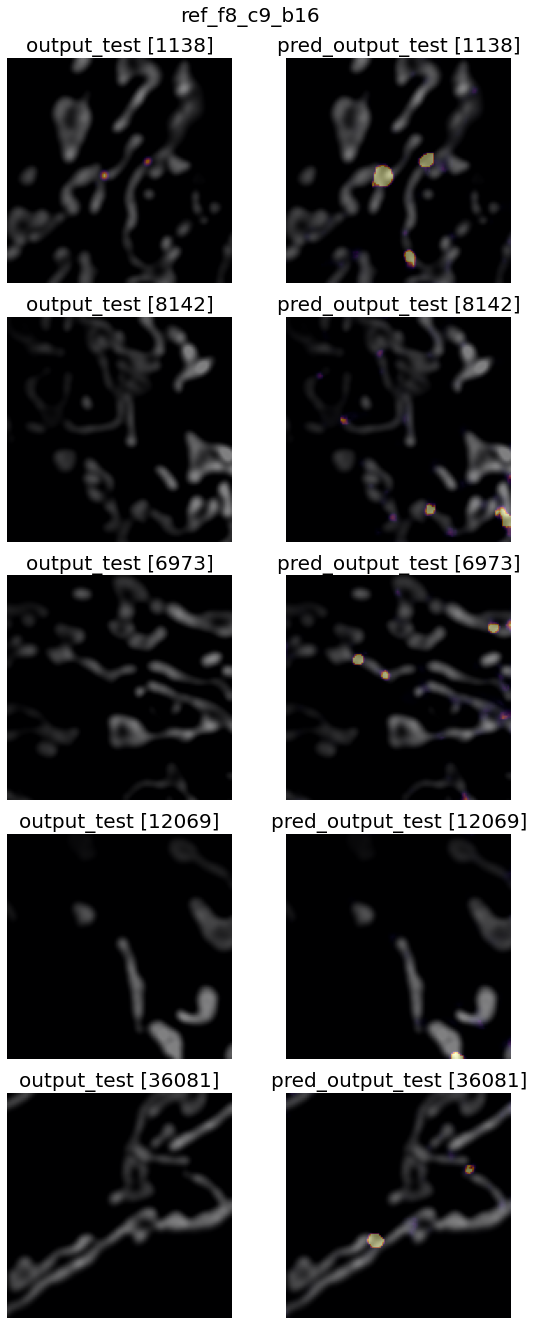

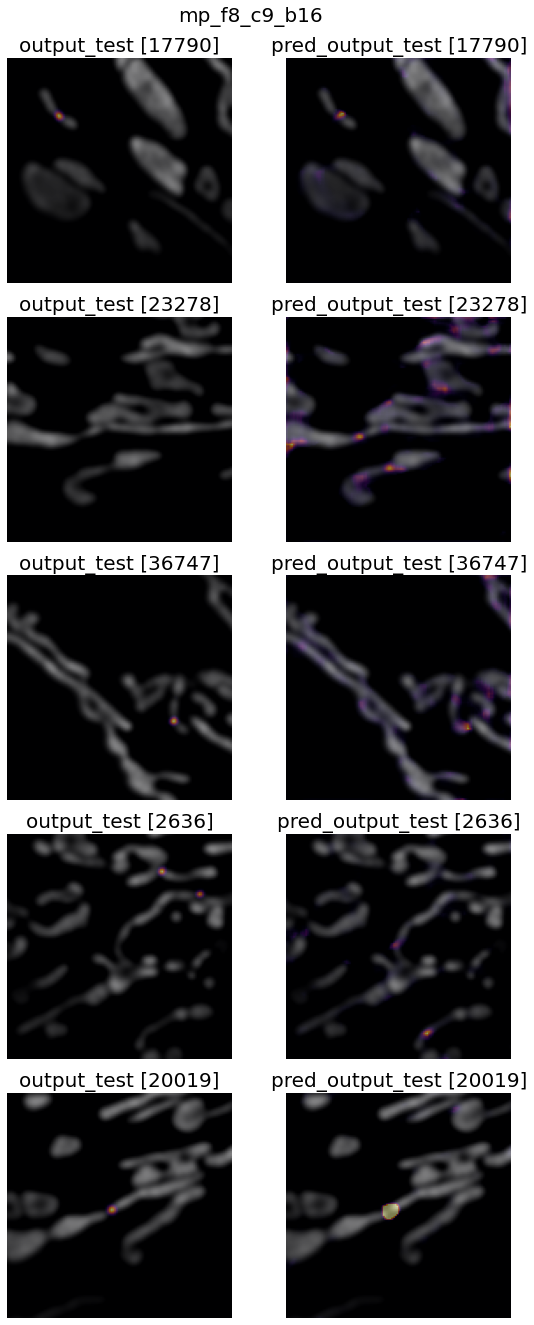

In [30]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [31]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics
Done.


### All metrics

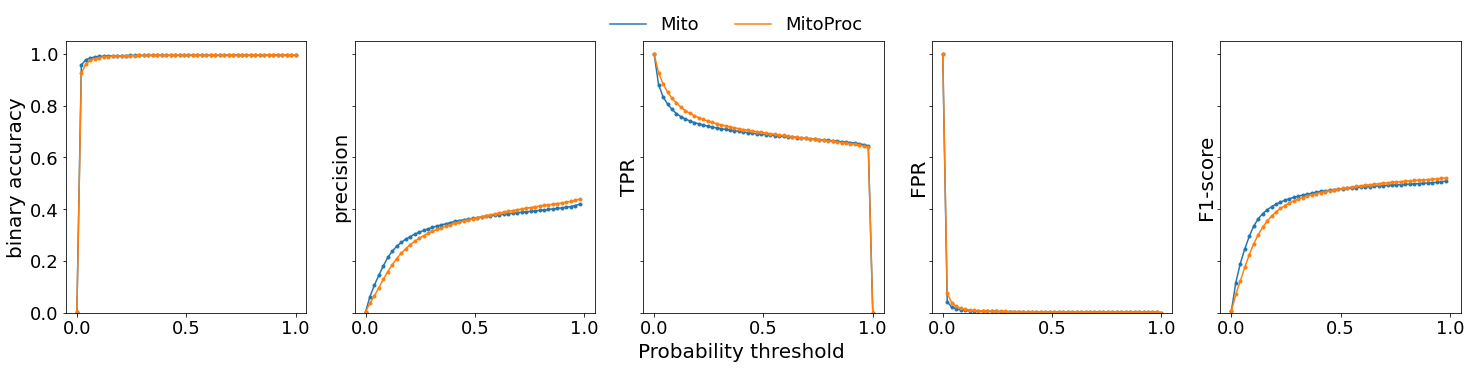

In [32]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['Mito', 'MitoProc'],
           loc='upper center', ncol=4, framealpha=0)

plt.show()

### metricAtMaxThreshold

In [33]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

ref_f8_c9_b16  mp_f8_c9_b16
binary accuracy       0.996018      0.996322
precision             0.419817      0.439567
TPR                   0.645070      0.639223
FPR                   0.002857      0.002557
F1-score              0.508620      0.520919

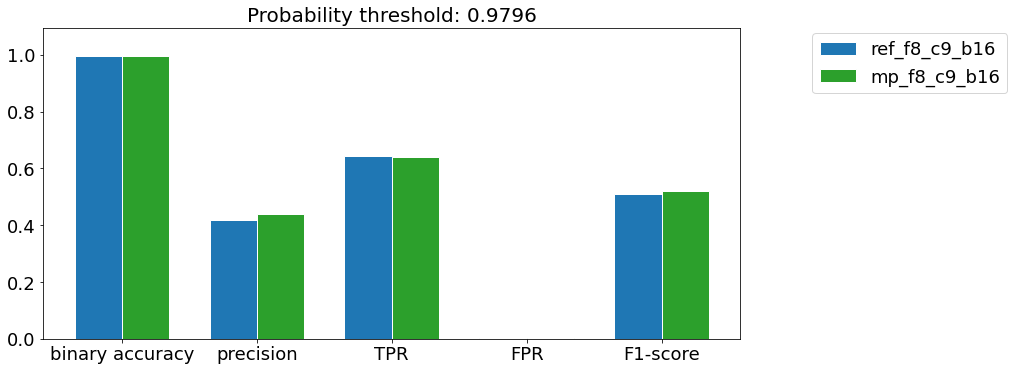

In [34]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'ref_f8_c9_b16': 0.0031948110219594595, 'mp_f8_c9_b16': 0.003128216717694257}


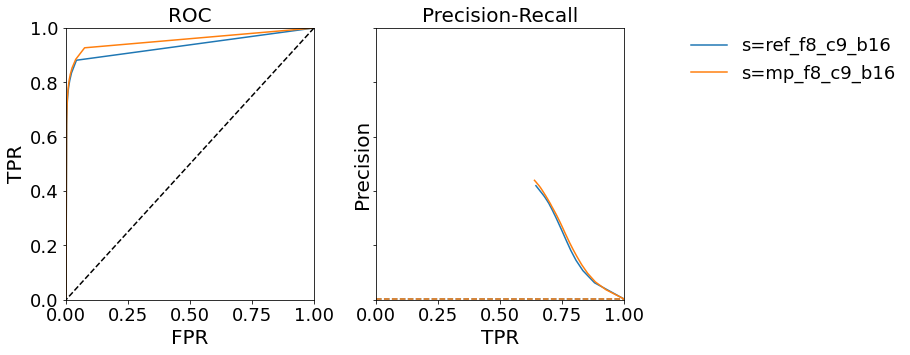

In [35]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

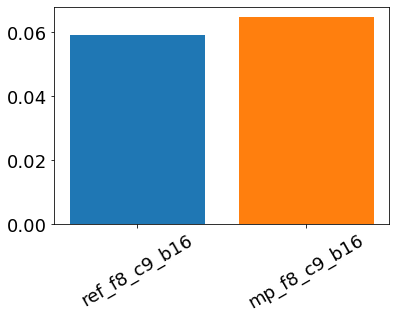

In [36]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

In [37]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats = fissionStats.T


Model name: ref_f8_c9_b16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3359.67it/s]



Model name: mp_f8_c9_b16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:02<00:00, 3615.20it/s]


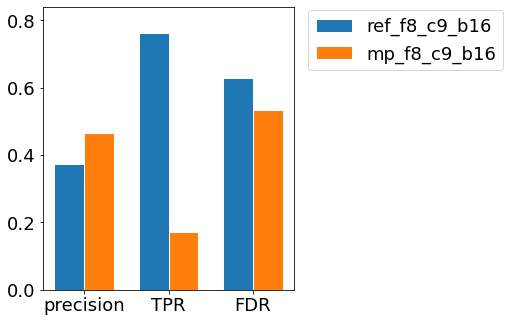

In [38]:
plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], color=colors)
plt.show()

## Mito & WatProc, different spot sizes

Precision-Recall AUC is 10 times bigger after dilating fissions with a disk-shaped gaussian kernel. The highest mean intensity threshold of 22.2 had the best performance.

In [39]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = optimal_sigma.shape[0]


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold


In [40]:
#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'wp')
folder_name = [model_name for model_name in folder_name if 'mp' not in model_name and 'aug' not in model_name] 
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/model.h5
Done.

Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/history
Done.

Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/frames_test
Done.


In [41]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
  print('\nModel: %s'%model_name)
  #Outputs
  output_data = util.load_h5(data_path, 'WatProc_s%.1f_t%.1f'%(s, t))
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  #Labels
  labels = util.load_h5(data_path, 'proc_labels_s%.1f_t%.1f'%(s, t))
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels

  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name]) 

del input_data


Model: wp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/WatProc_s1.9_t3.5.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s1.9_t3.5.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_f8_c9_b16_s2.1_t11.3

Loading H:/Santi/Data/WatProc_s2.1_t11.3.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s2.1_t11.3.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_f8_c9_b16_s2.2_t16.0

Loading H:/Santi/Data/WatProc_s2.2_t16.0.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s2.2_t16.0.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_f8_c9_b16_s2.2_t19.1

Loading H:/Santi/Data/WatProc_s2.2_t19.1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s2.2_t19.1.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_f8_c9_b16_s2.2_t22.2

Loading H:/Santi/Data/WatProc_s2.2_t22.2.h5
Converting to array
Outputs: (37000, 128, 128)

Lo

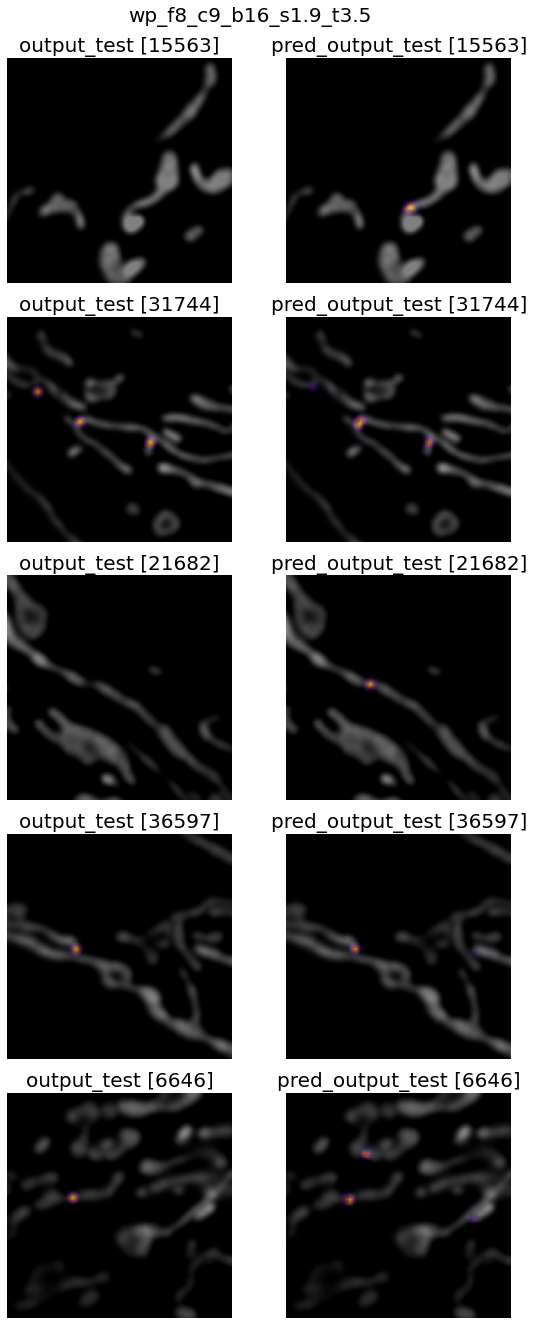

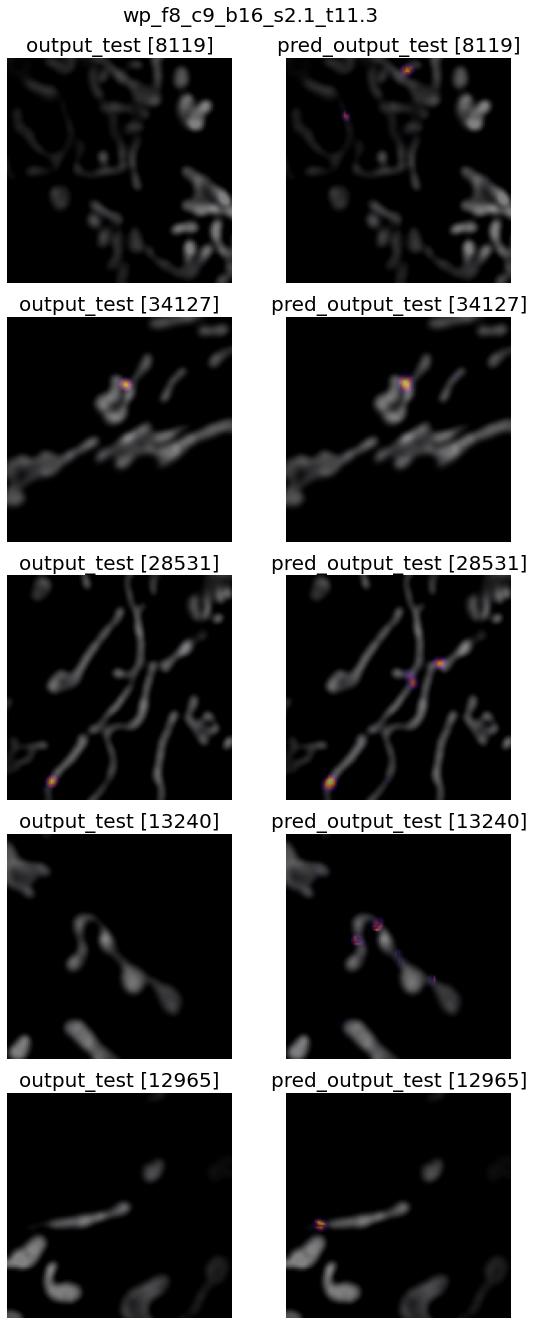

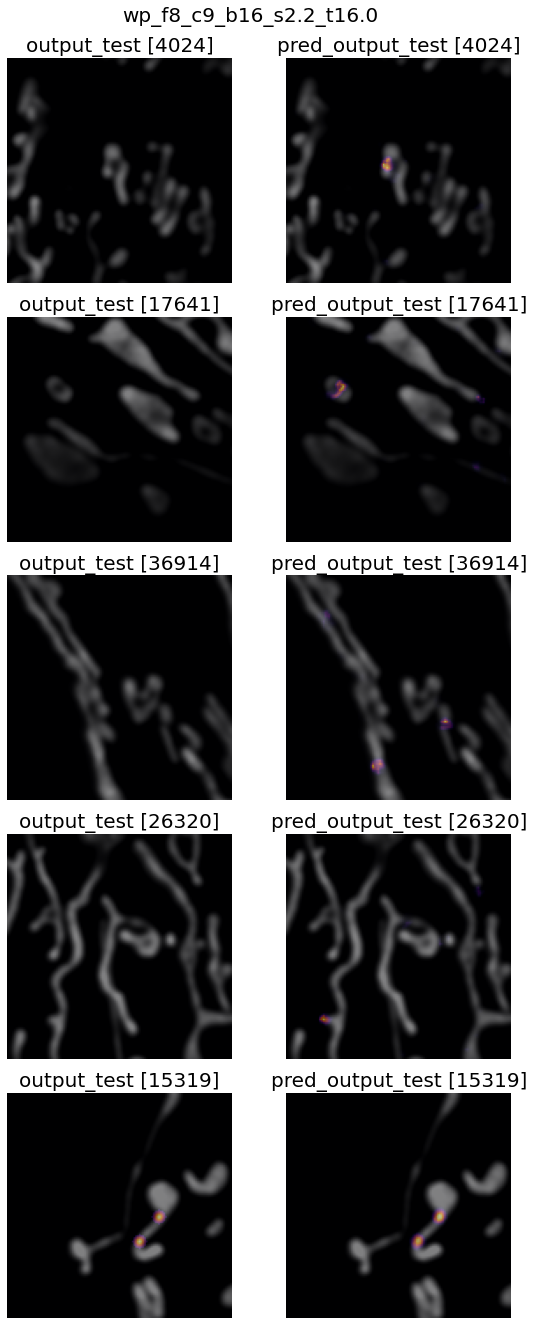

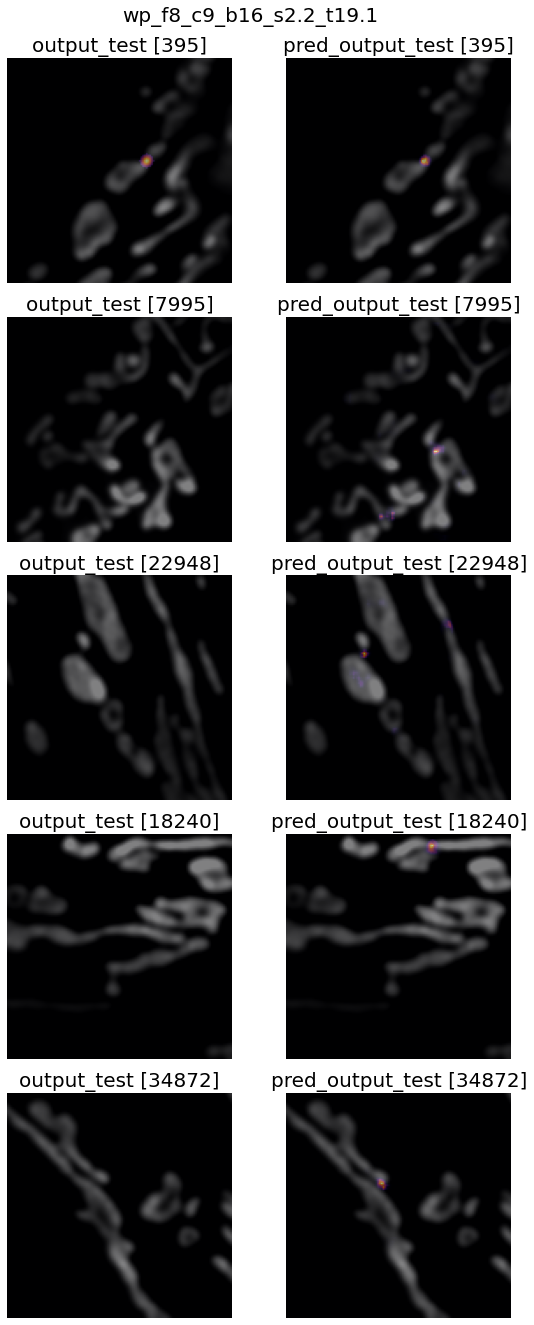

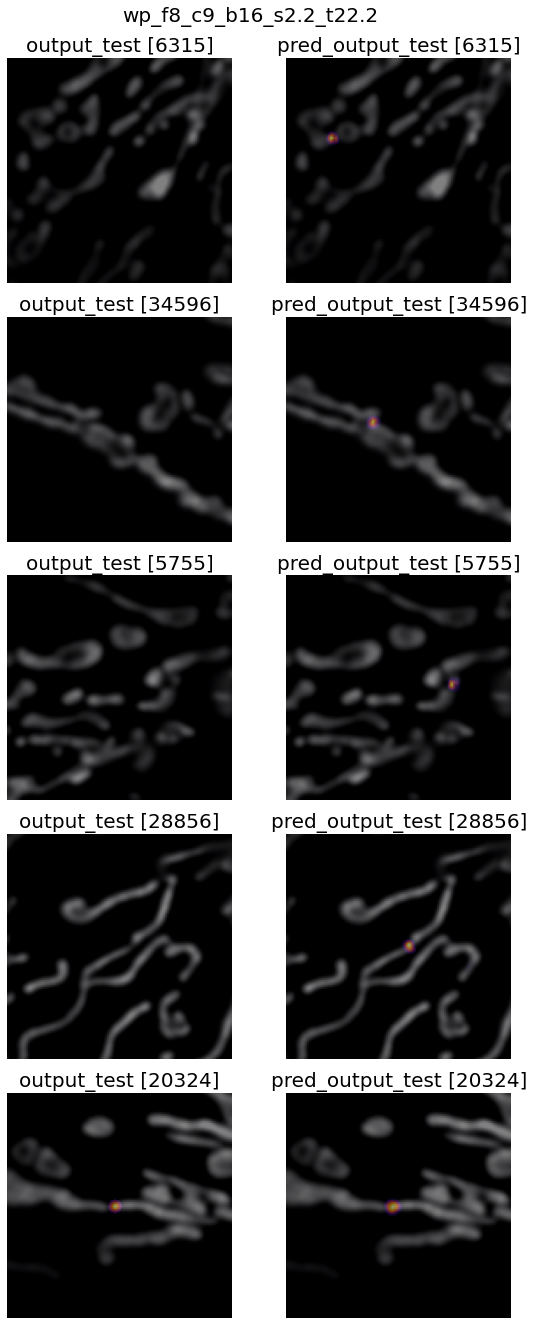

In [42]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

In [43]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/metrics
Done.


### All metrics

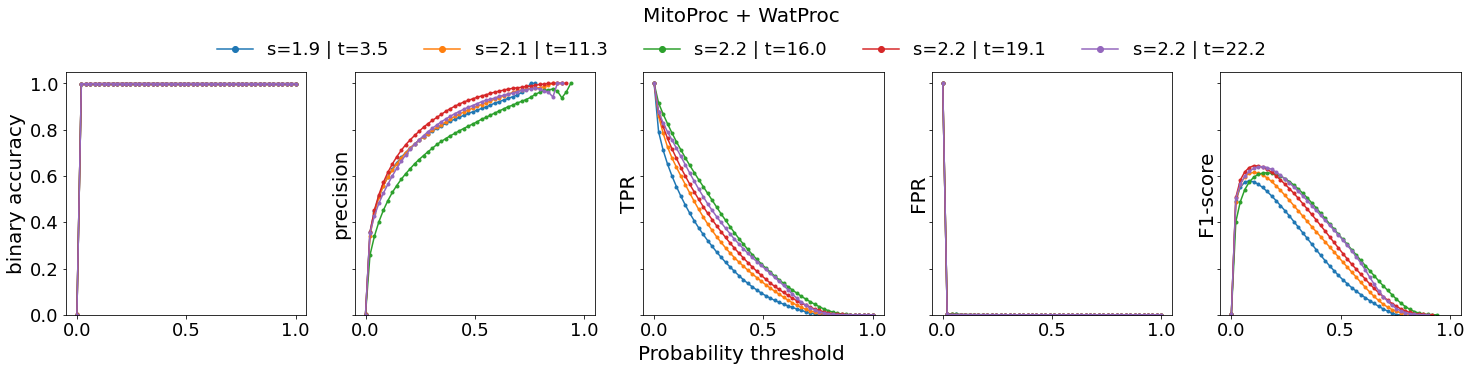

In [44]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f | t=%.1f'%(s, t) for s, t in zip(optimal_sigma, threshold)],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=5, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

### metricAtMaxF1

In [45]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][metrics[model_name]['F1-score']==np.nanmax(metrics[model_name]['F1-score'])][0]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

wp_f8_c9_b16_s1.9_t3.5  wp_f8_c9_b16_s2.1_t11.3  \
binary accuracy                0.997640                 0.998637   
precision                      0.558499                 0.593759   
TPR                            0.599924                 0.637598   
FPR                            0.001283                 0.000746   
F1-score                       0.578470                 0.614898   

                 wp_f8_c9_b16_s2.2_t16.0  wp_f8_c9_b16_s2.2_t19.1  \
binary accuracy                 0.999014                 0.999237   
precision                       0.585407                 0.615019   
TPR                             0.645446                 0.676148   
FPR                             0.000556                 0.000433   
F1-score                        0.613962                 0.644136   

                 wp_f8_c9_b16_s2.2_t22.2  
binary accuracy                 0.999372  
precision                       0.633093  
TPR                             0.647923  
FPR                             0.000324  
F1-score                        0.640422

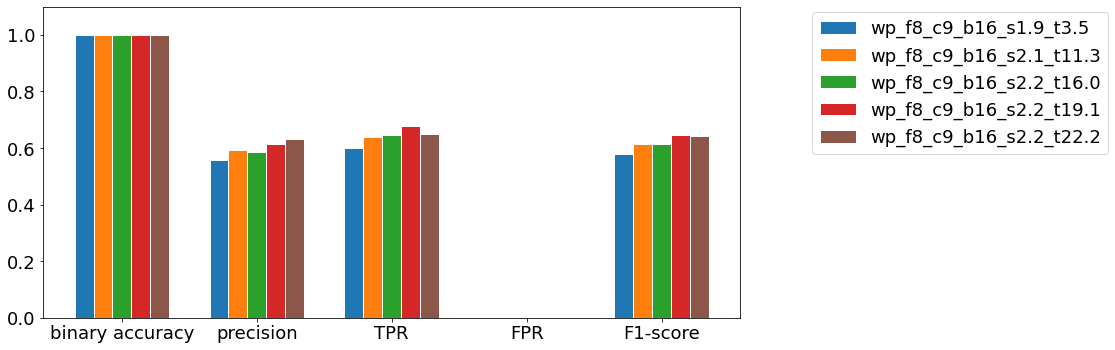

In [46]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'wp_f8_c9_b16_s1.9_t3.5': 0.0026989498653927366, 'wp_f8_c9_b16_s2.1_t11.3': 0.0017063037769214527, 'wp_f8_c9_b16_s2.2_t16.0': 0.001215259448902027, 'wp_f8_c9_b16_s2.2_t19.1': 0.0010218439875422298, 'wp_f8_c9_b16_s2.2_t22.2': 0.0008626412056587838}


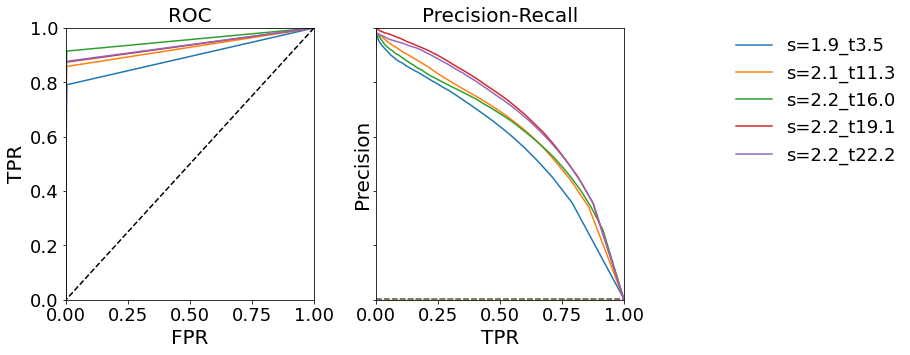

In [47]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

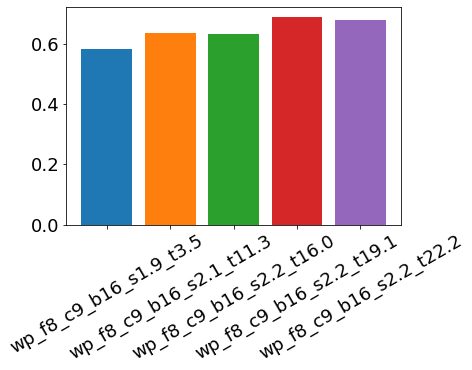

In [48]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

In [49]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats = fissionStats.T


Model name: wp_f8_c9_b16_s1.9_t3.5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 3978.26it/s]



Model name: wp_f8_c9_b16_s2.1_t11.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 5443.58it/s]



Model name: wp_f8_c9_b16_s2.2_t16.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 6765.60it/s]



Model name: wp_f8_c9_b16_s2.2_t19.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:00<00:00, 7638.56it/s]



Model name: wp_f8_c9_b16_s2.2_t22.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:00<00:00, 8374.44it/s]


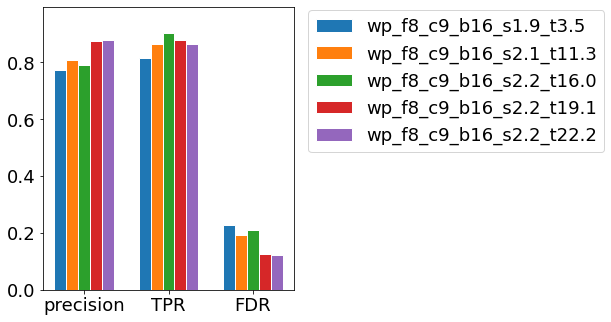

In [50]:
plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], color=colors)
plt.show()

## MitoProc & WatProc, different spot sizes

Contrast enhancement of input data does not improve the performance

In [42]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = optimal_sigma.shape[0]

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'wp_mp')


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold


In [43]:
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/model.h5
Done.

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/history
Done.

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/frames_test
Done.


In [44]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
  print('\nModel: %s'%model_name)
  #Outputs
  output_data = util.load_h5(data_path, 'WatProc_s%.1f_t%.1f'%(s, t))
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  #Labels
  labels = util.load_h5(data_path, 'proc_labels_s%.1f_t%.1f'%(s, t))
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels

  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name]) 

del input_data


Model: wp_mp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/WatProc_s1.9_t3.5.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s1.9_t3.5.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_mp_f8_c9_b16_s2.1_t11.3

Loading H:/Santi/Data/WatProc_s2.1_t11.3.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s2.1_t11.3.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_mp_f8_c9_b16_s2.2_t16.0

Loading H:/Santi/Data/WatProc_s2.2_t16.0.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s2.2_t16.0.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_mp_f8_c9_b16_s2.2_t19.1

Loading H:/Santi/Data/WatProc_s2.2_t19.1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/proc_labels_s2.2_t19.1.h5
Converting to array
Labels: (37000, 128, 128)

Model: wp_mp_f8_c9_b16_s2.2_t22.2

Loading H:/Santi/Data/WatProc_s2.2_t22.2.h5
Converting to array
Outputs: (37000

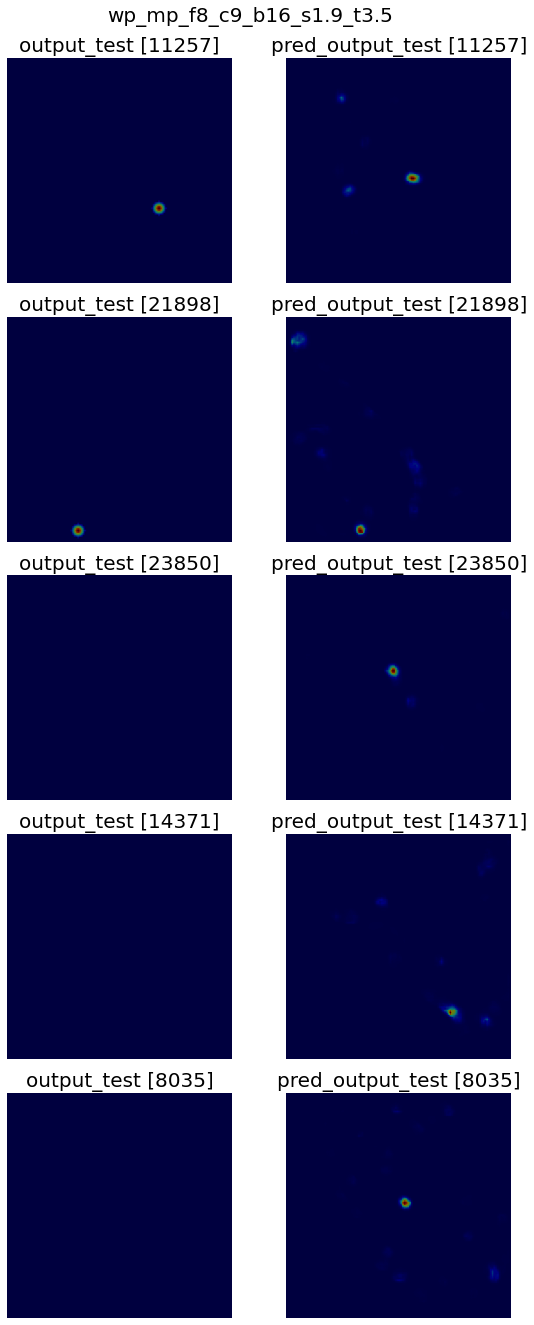

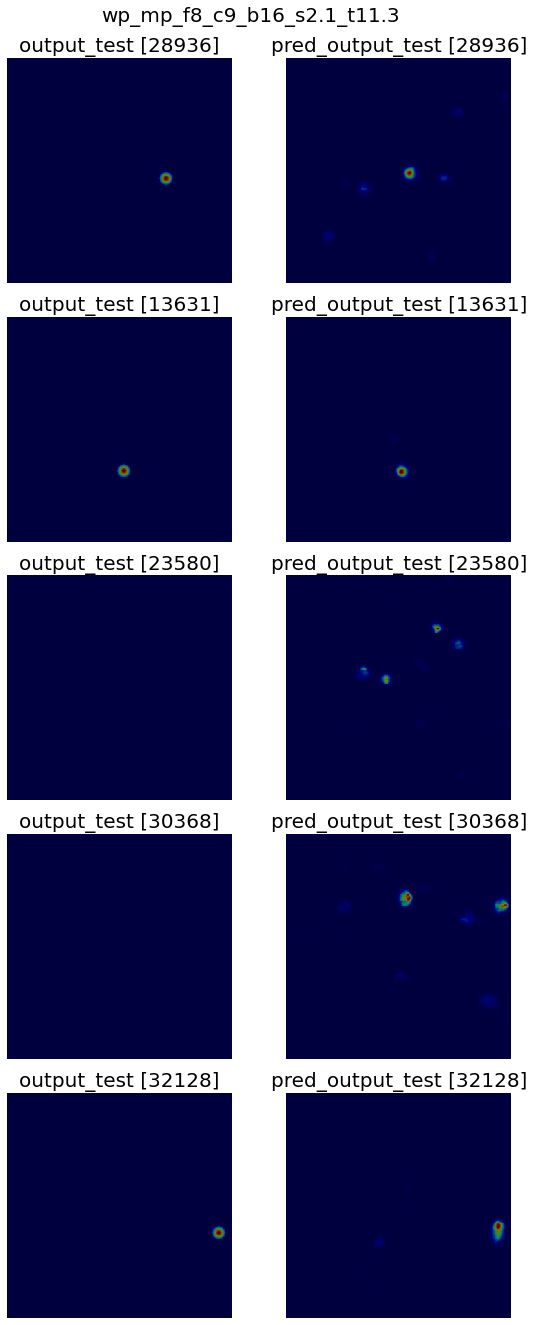

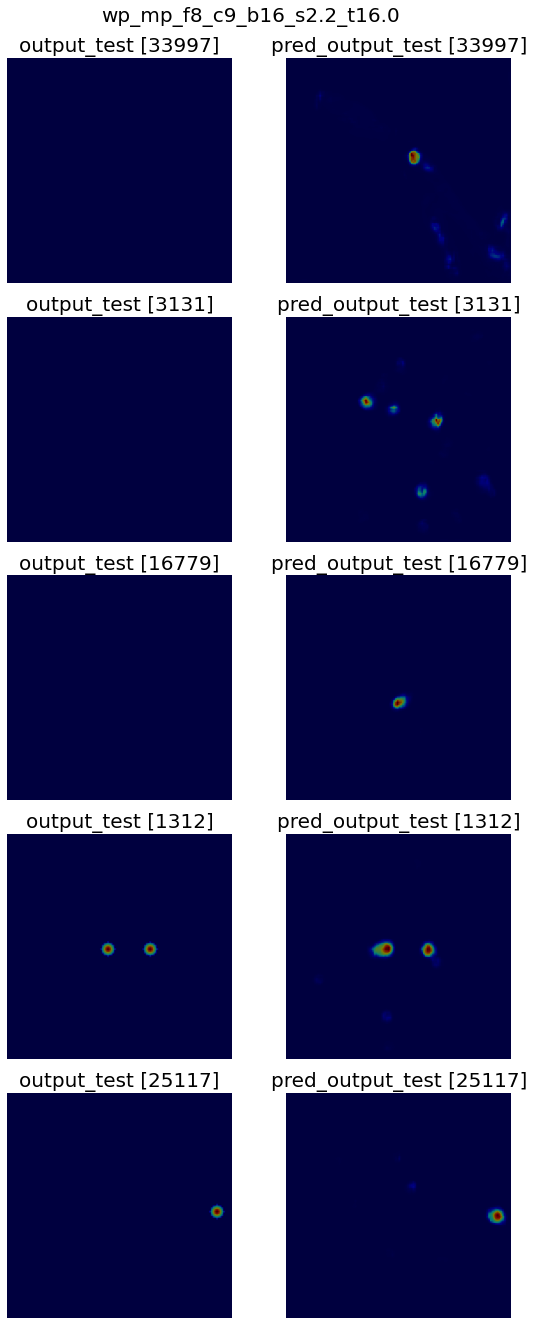

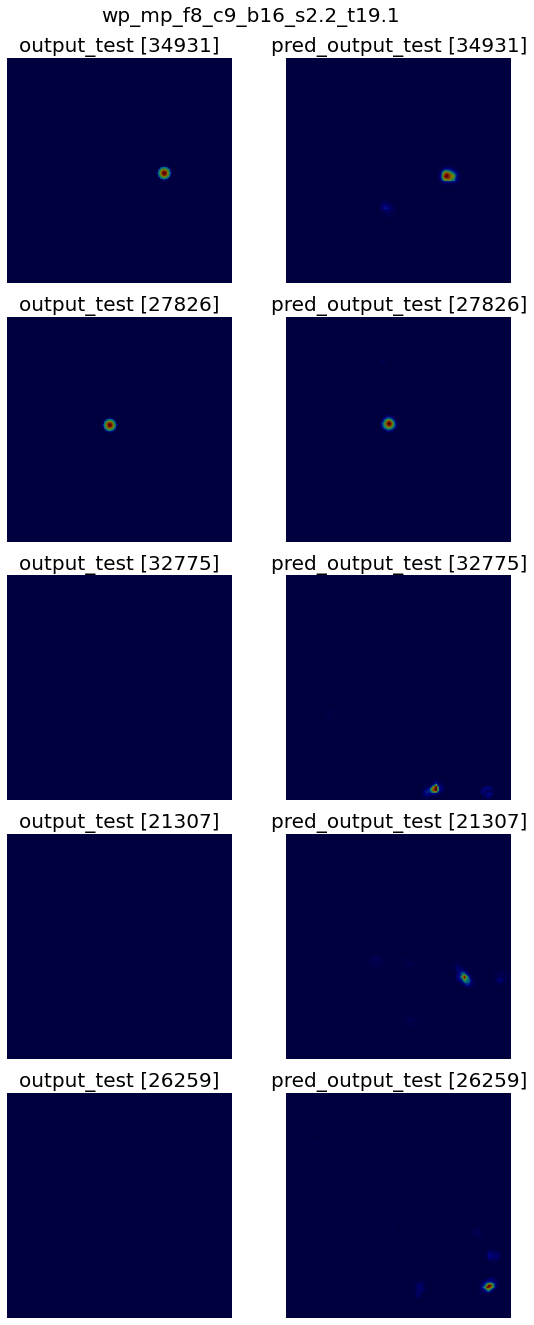

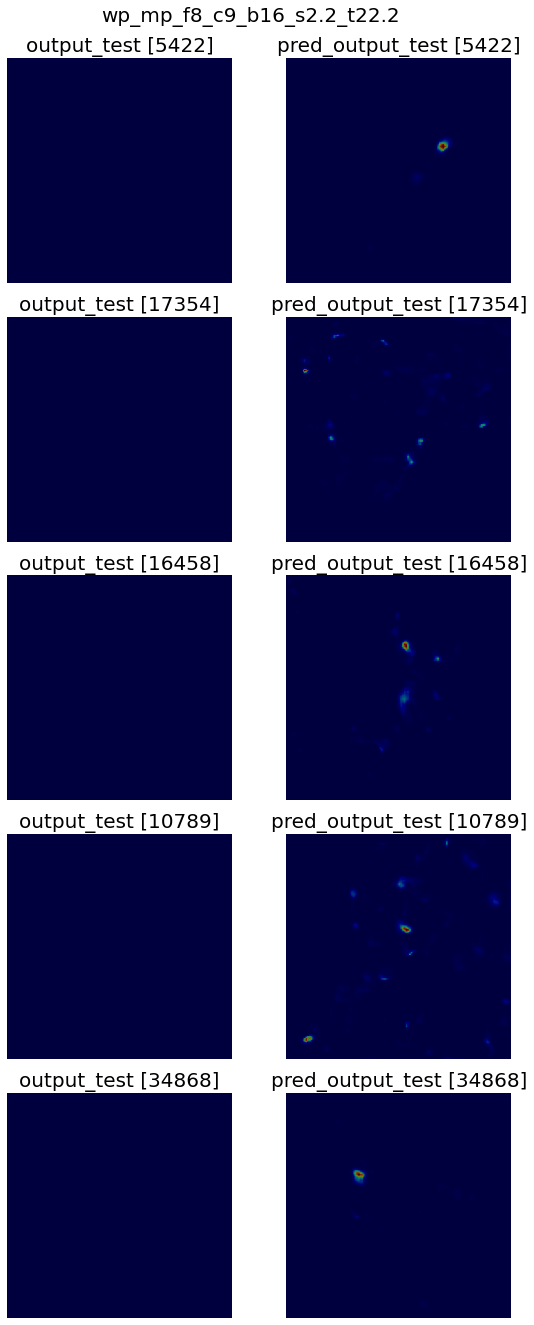

In [45]:
for model_name in folder_name:
  plotting.plot_outputs(0*input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'jet'])
  plt.show()
  print('\n')

In [46]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/metrics
Done.


### All metrics

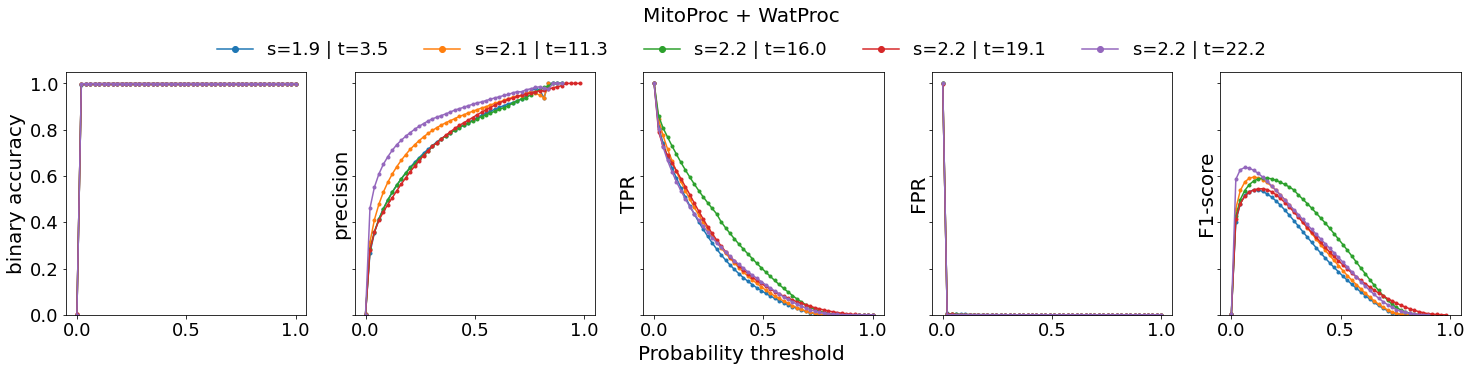

In [47]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f | t=%.1f'%(s, t) for s, t in zip(optimal_sigma, threshold)],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=5, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

### metricAtMaxF1

In [48]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][metrics[model_name]['F1-score']==np.nanmax(metrics[model_name]['F1-score'])][0]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

wp_mp_f8_c9_b16_s1.9_t3.5  wp_mp_f8_c9_b16_s2.1_t11.3  \
binary accuracy                   0.997340                    0.998611   
precision                         0.496127                    0.572585   
TPR                               0.590897                    0.619432   
FPR                               0.001586                    0.000763   
F1-score                          0.539381                    0.595088   

                 wp_mp_f8_c9_b16_s2.2_t16.0  wp_mp_f8_c9_b16_s2.2_t19.1  \
binary accuracy                    0.998938                    0.999083   
precision                          0.560177                    0.535637   
TPR                                0.625857                    0.553856   
FPR                                0.000603                    0.000476   
F1-score                           0.591199                    0.544594   

                 wp_mp_f8_c9_b16_s2.2_t22.2  
binary accuracy                    0.999349  
precision                          0.608412  
TPR                                0.667272  
FPR                                0.000367  
F1-score                           0.636484

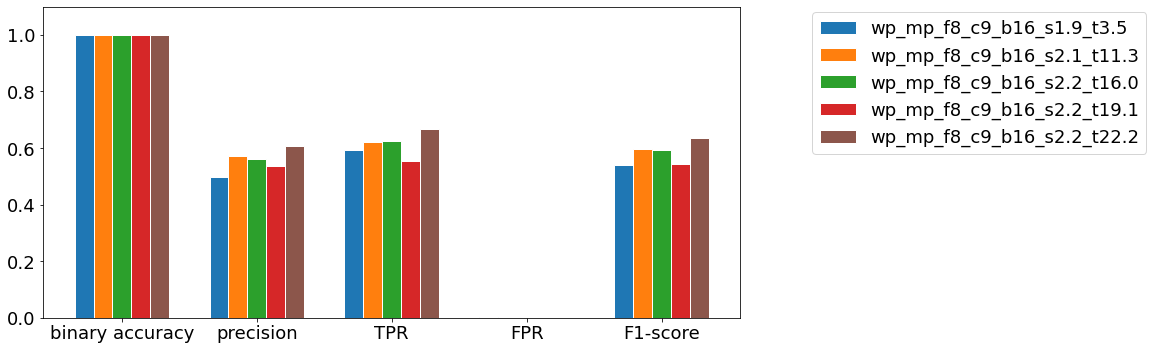

In [49]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'wp_mp_f8_c9_b16_s1.9_t3.5': 0.0026358692066089525, 'wp_mp_f8_c9_b16_s2.1_t11.3': 0.0016482626425253378, 'wp_mp_f8_c9_b16_s2.2_t16.0': 0.0012264767208614864, 'wp_mp_f8_c9_b16_s2.2_t19.1': 0.000990344898120777, 'wp_mp_f8_c9_b16_s2.2_t22.2': 0.0008540055558488175}


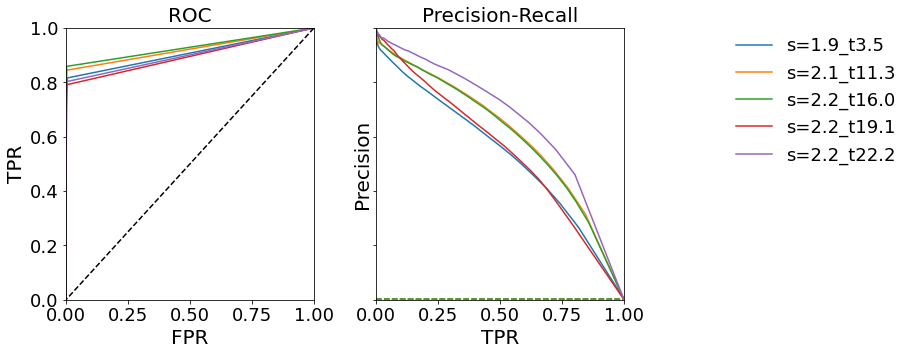

In [50]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

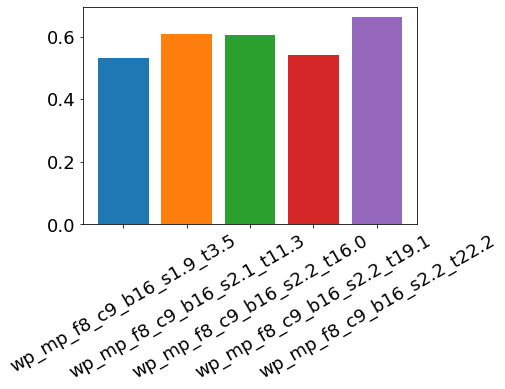

In [51]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

In [52]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats = fissionStats.T


Model name: wp_mp_f8_c9_b16_s1.9_t3.5


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 3840.64it/s]



Model name: wp_mp_f8_c9_b16_s2.1_t11.3


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 5278.16it/s]



Model name: wp_mp_f8_c9_b16_s2.2_t16.0


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 6326.50it/s]



Model name: wp_mp_f8_c9_b16_s2.2_t19.1


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 7206.13it/s]



Model name: wp_mp_f8_c9_b16_s2.2_t22.2


100%|████████████████████████████████████████████████████████| 7400/7400 [00:00<00:00, 8202.71it/s]


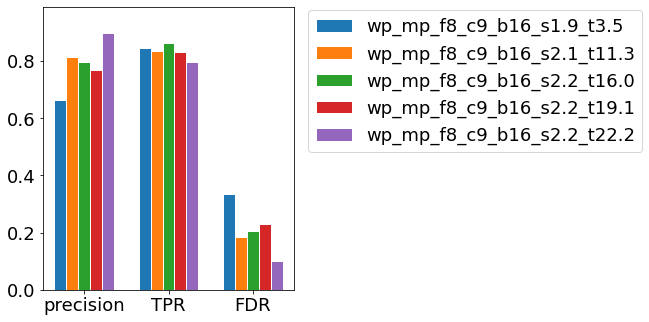

In [53]:
plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], color=colors)
plt.show()

## Augmented Mito and WatProc without ElasticTransform



Training preexisting model on an augmented dataset worsened its performance.

In [17]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = optimal_sigma.shape[0]

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'aug2_wp')


Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold

Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)


In [18]:
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s1.9_t3.5/model.h5

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.1_t11.3/model.h5

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t16.0/model.h5

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t19.1/model.h5

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t22.2/model.h5
Done.

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s1.9_t3.5/history

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.1_t11.3/history

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t16.0/history

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t19.1/history

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t22.2/history
Done.

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s1.9_t3.5/frames_test

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.1_t11.3/frames_test

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t16.0/frames_test

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t19.1/frames_test

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t22.2/frames_test
Done.


In [19]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
  print('\nModel: %s'%model_name)
  #Outputs
  output_data = util.load_h5(data_path, 'aug2_WatProc_s%.1f_t%.1f'%(s, t))
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  #Labels
  labels = util.load_h5(data_path, 'aug2_labels_s%.1f_t%.1f'%(s, t))
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels

  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name]) 

del input_data


Model: aug2_wp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/aug2_WatProc_s1.9_t3.5.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug2_labels_s1.9_t3.5.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug2_wp_f8_c9_b16_s2.1_t11.3

Loading H:/Santi/Data/aug2_WatProc_s2.1_t11.3.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug2_labels_s2.1_t11.3.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug2_wp_f8_c9_b16_s2.2_t16.0

Loading H:/Santi/Data/aug2_WatProc_s2.2_t16.0.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug2_labels_s2.2_t16.0.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug2_wp_f8_c9_b16_s2.2_t19.1

Loading H:/Santi/Data/aug2_WatProc_s2.2_t19.1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug2_labels_s2.2_t19.1.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug2_wp_f8_c9_b16_s2.2_t22.2

Loading H:/Santi/Data/aug2_WatProc_s2.2_t22.2.h5


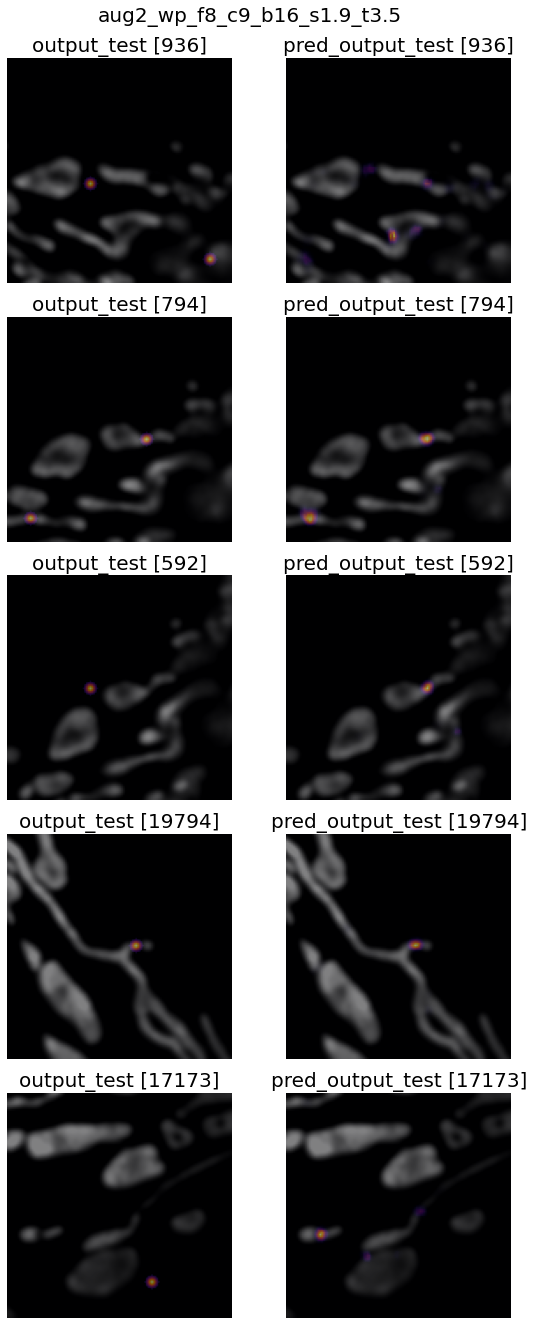

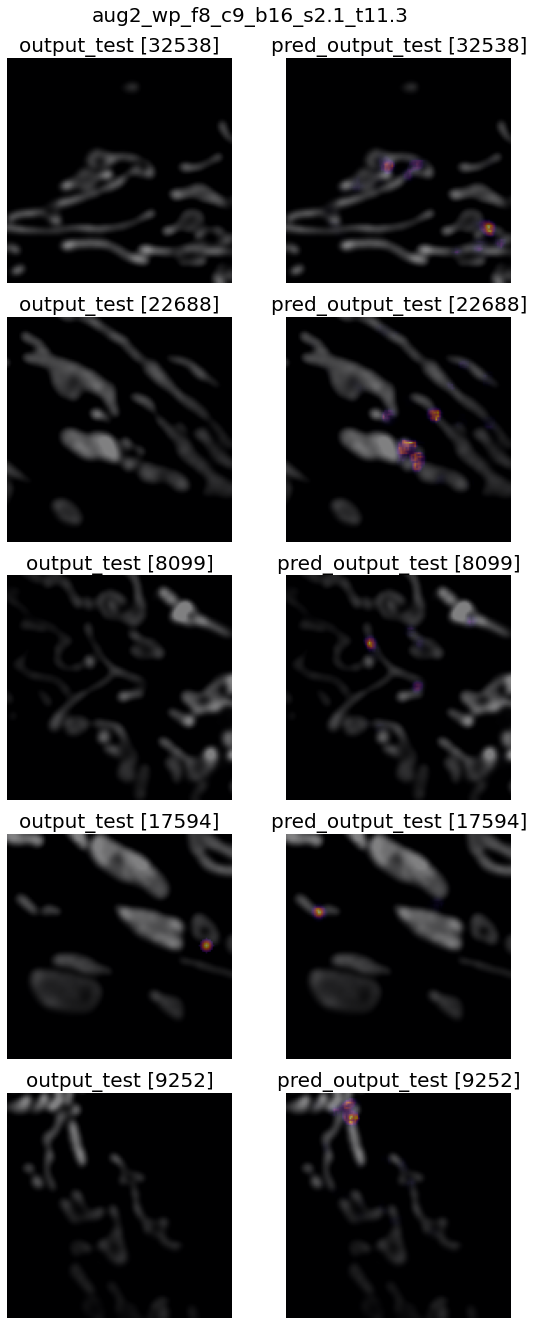

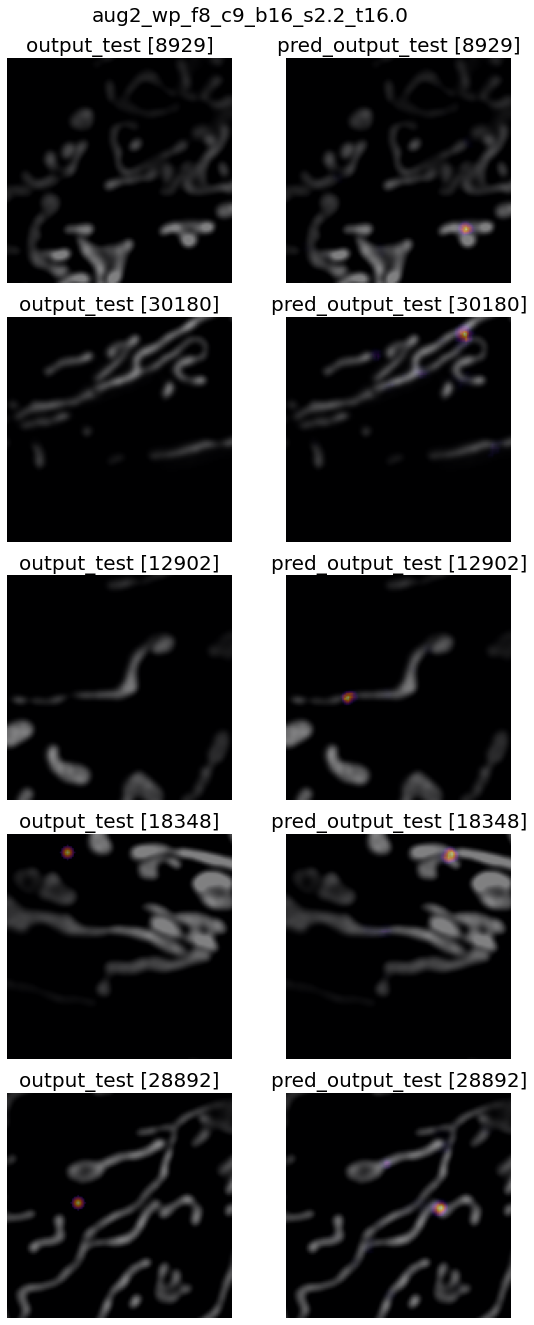

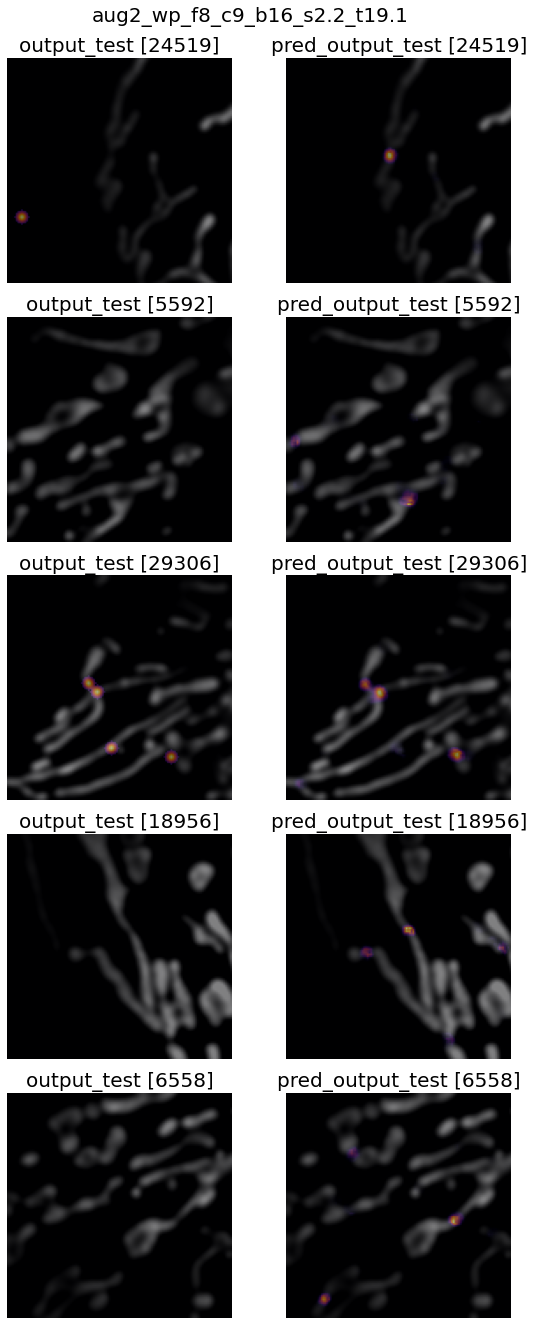

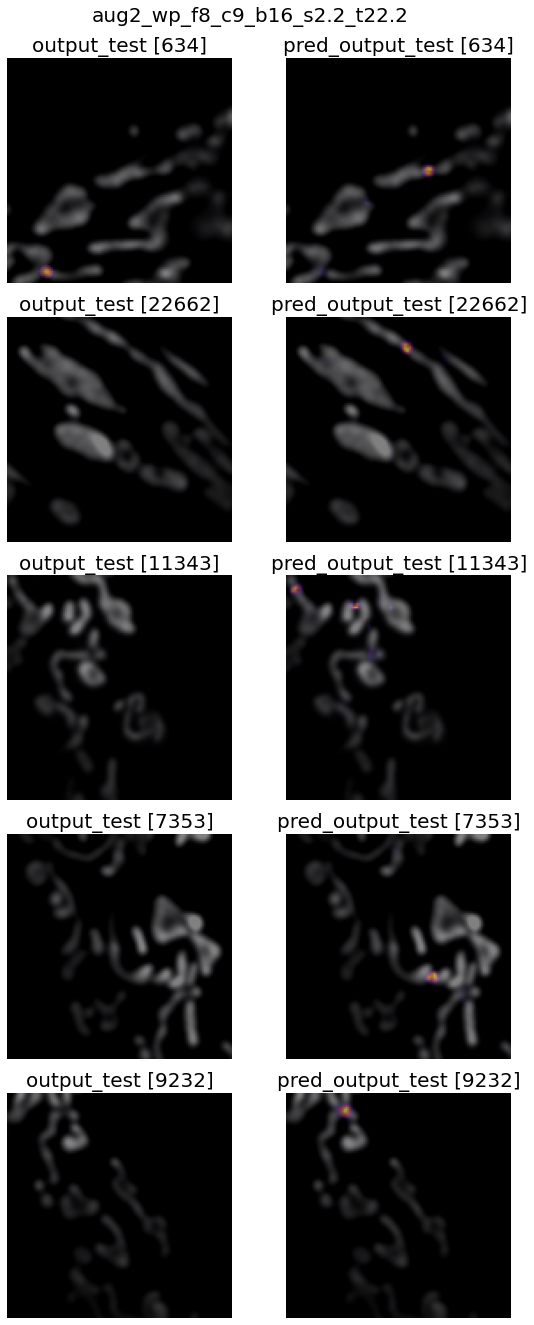

In [20]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

In [21]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

aug2_wp_f8_c9_b16_s1.9_t3.5: 0.46


100%|██████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]
C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:110: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),
C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:113: RuntimeWarning: invalid value encountered in true_divide
  metrics['F1-score'] = 2*(metrics['precision']*metrics['TPR'])/(metrics['precision']+metrics['TPR'])


aug2_wp_f8_c9_b16_s2.1_t11.3: 0.63


100%|██████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


aug2_wp_f8_c9_b16_s2.2_t16.0: 0.71


100%|██████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


aug2_wp_f8_c9_b16_s2.2_t19.1: 0.76


100%|██████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


aug2_wp_f8_c9_b16_s2.2_t22.2: 0.78


100%|██████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Saving H:/Santi/Models/aug2_wp_f8_c9_b16_s1.9_t3.5/metrics

Saving H:/Santi/Models/aug2_wp_f8_c9_b16_s2.1_t11.3/metrics

Saving H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t16.0/metrics

Saving H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t19.1/metrics

Saving H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t22.2/metrics
Done.


In [22]:
thresholds = np.linspace(0, 0.02, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s1.9_t3.5/metrics

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.1_t11.3/metrics

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t16.0/metrics

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t19.1/metrics

Loading H:/Santi/Models/aug2_wp_f8_c9_b16_s2.2_t22.2/metrics
Done.


### All metrics

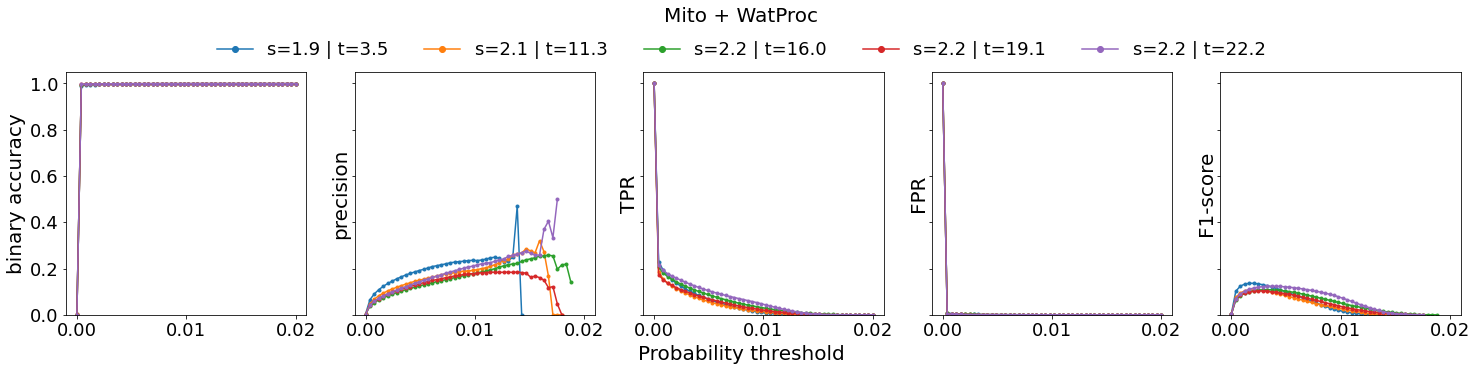

In [23]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('Mito + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f | t=%.1f'%(s, t) for s, t in zip(optimal_sigma, threshold)],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=5, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

### metricAtMaxF1

In [24]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][metrics[model_name]['F1-score']==np.nanmax(metrics[model_name]['F1-score'])][0]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

aug2_wp_f8_c9_b16_s1.9_t3.5  aug2_wp_f8_c9_b16_s2.1_t11.3  \
binary accuracy                     0.994870                      0.997032   
precision                           0.123327                      0.103399   
TPR                                 0.152029                      0.113092   
FPR                                 0.002882                      0.001561   
F1-score                            0.136182                      0.108028   

                 aug2_wp_f8_c9_b16_s2.2_t16.0  aug2_wp_f8_c9_b16_s2.2_t19.1  \
binary accuracy                      0.997837                      0.998291   
precision                            0.102287                      0.104555   
TPR                                  0.115643                      0.101586   
FPR                                  0.001157                      0.000842   
F1-score                             0.108556                      0.103049   

                 aug2_wp_f8_c9_b16_s2.2_t22.2  
binary accuracy                      0.998548  
precision                            0.121878  
TPR                                  0.125505  
FPR                                  0.000739  
F1-score                             0.123665

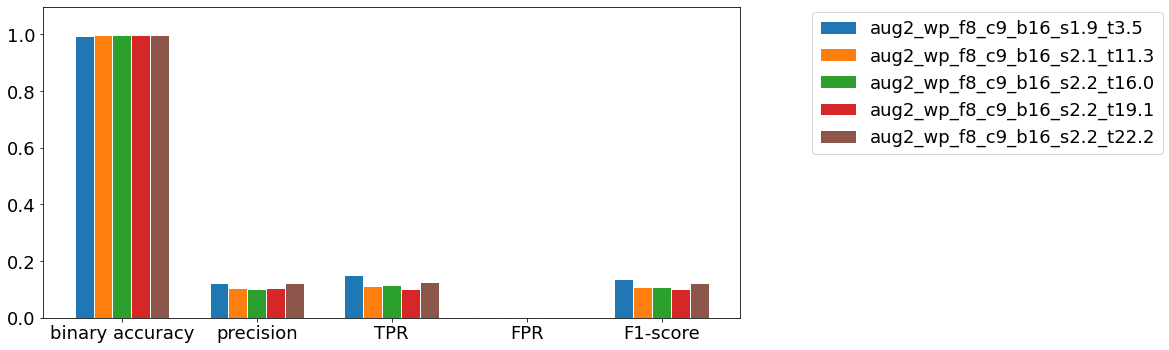

In [25]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'aug2_wp_f8_c9_b16_s1.9_t3.5': 0.0026597471494932434, 'aug2_wp_f8_c9_b16_s2.1_t11.3': 0.001589404956714527, 'aug2_wp_f8_c9_b16_s2.2_t16.0': 0.0011388830236486486, 'aug2_wp_f8_c9_b16_s2.2_t19.1': 0.0009665164432010135, 'aug2_wp_f8_c9_b16_s2.2_t22.2': 0.0008161555109797297}


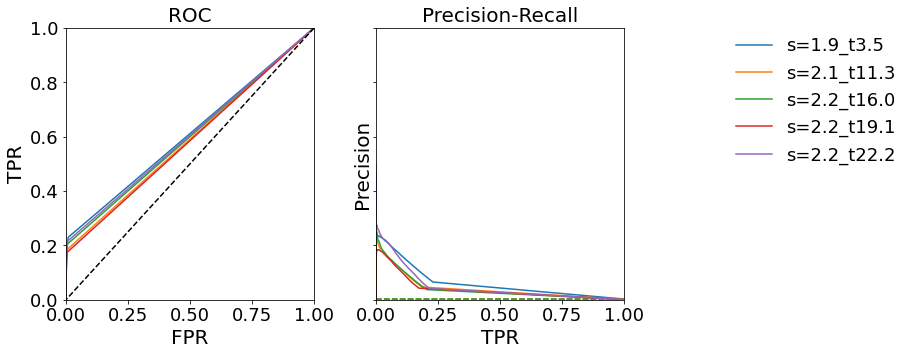

In [26]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

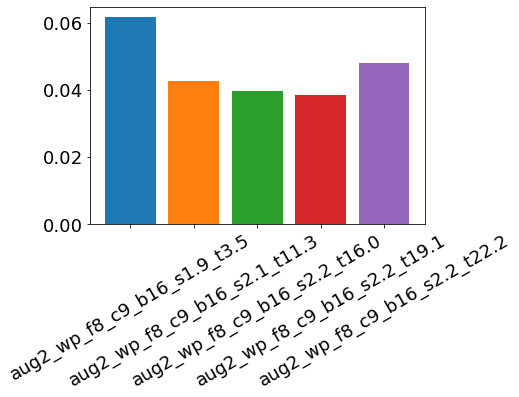

In [27]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

In [28]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats = fissionStats.T


Model name: aug2_wp_f8_c9_b16_s1.9_t3.5


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 3883.77it/s]



Model name: aug2_wp_f8_c9_b16_s2.1_t11.3


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 5468.62it/s]



Model name: aug2_wp_f8_c9_b16_s2.2_t16.0


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 6784.14it/s]



Model name: aug2_wp_f8_c9_b16_s2.2_t19.1


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 7303.30it/s]



Model name: aug2_wp_f8_c9_b16_s2.2_t22.2


100%|████████████████████████████████████████████████████████| 7400/7400 [00:00<00:00, 8661.16it/s]


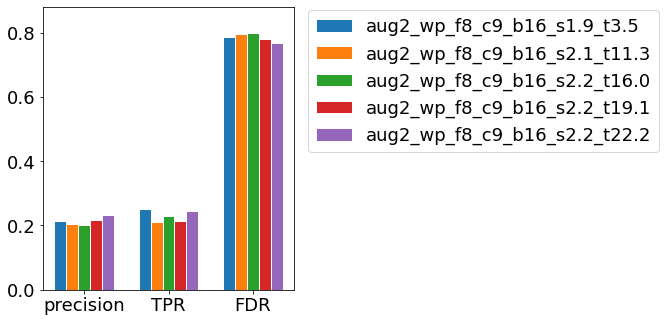

In [29]:
plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], color=colors)
plt.show()

## Augmented Mito and WatProc with ElasticTransform

Adding elastic deformations makes performance even worse

In [30]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = optimal_sigma.shape[0]

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'aug_wp')


Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold

Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)


In [31]:
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/model.h5
Done.

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/history
Done.

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/frames_test
Done.


In [32]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
  print('\nModel: %s'%model_name)
  #Outputs
  output_data = util.load_h5(data_path, 'aug_WatProc_s%.1f_t%.1f'%(s, t))
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  #Labels
  labels = util.load_h5(data_path, 'aug_labels_s%.1f_t%.1f'%(s, t))
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels

  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=0.2) 

del input_data


Model: aug_wp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/aug_WatProc_s1.9_t3.5.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug_labels_s1.9_t3.5.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.1_t11.3

Loading H:/Santi/Data/aug_WatProc_s2.1_t11.3.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug_labels_s2.1_t11.3.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.2_t16.0

Loading H:/Santi/Data/aug_WatProc_s2.2_t16.0.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug_labels_s2.2_t16.0.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.2_t19.1

Loading H:/Santi/Data/aug_WatProc_s2.2_t19.1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/aug_labels_s2.2_t19.1.h5
Converting to array
Labels: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.2_t22.2

Loading H:/Santi/Data/aug_WatProc_s2.2_t22.2.h5
Converting to 

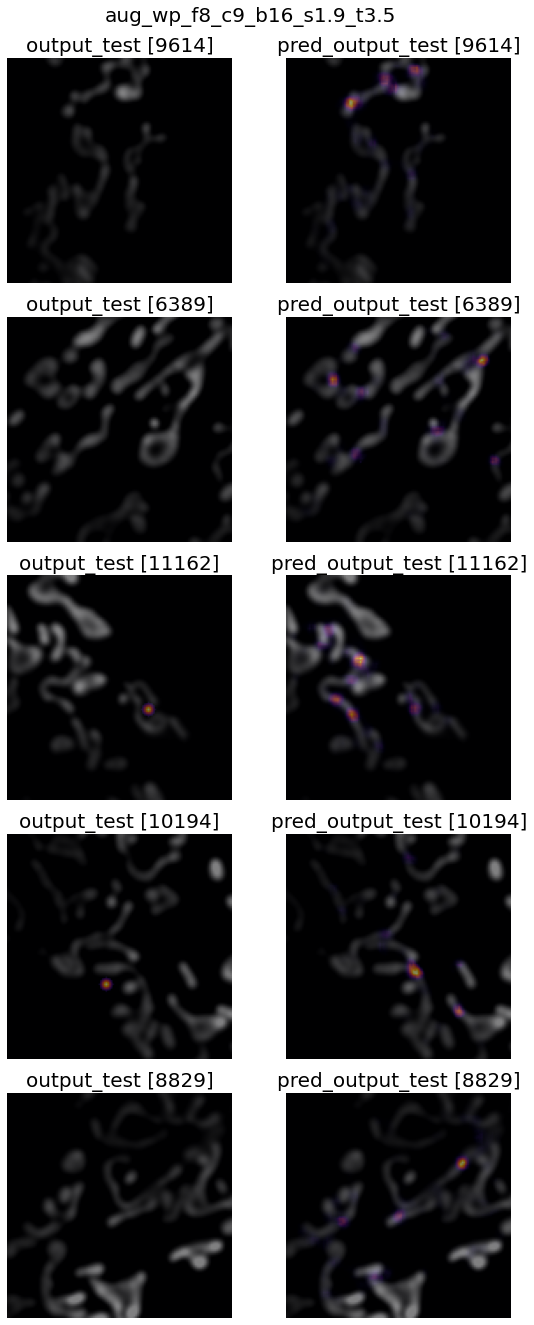

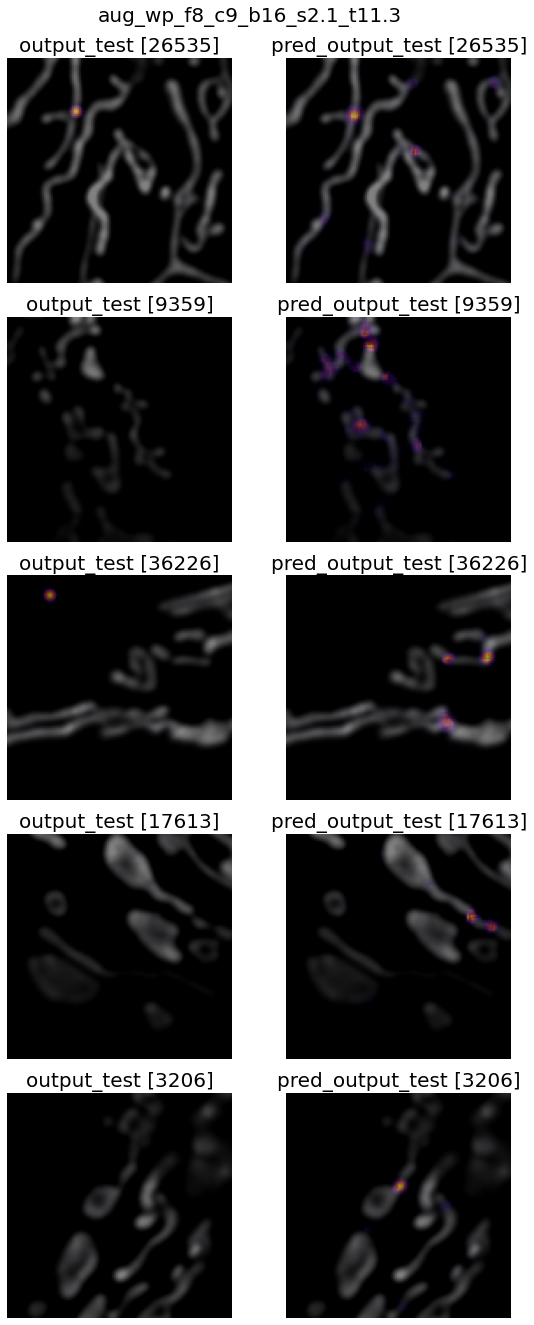

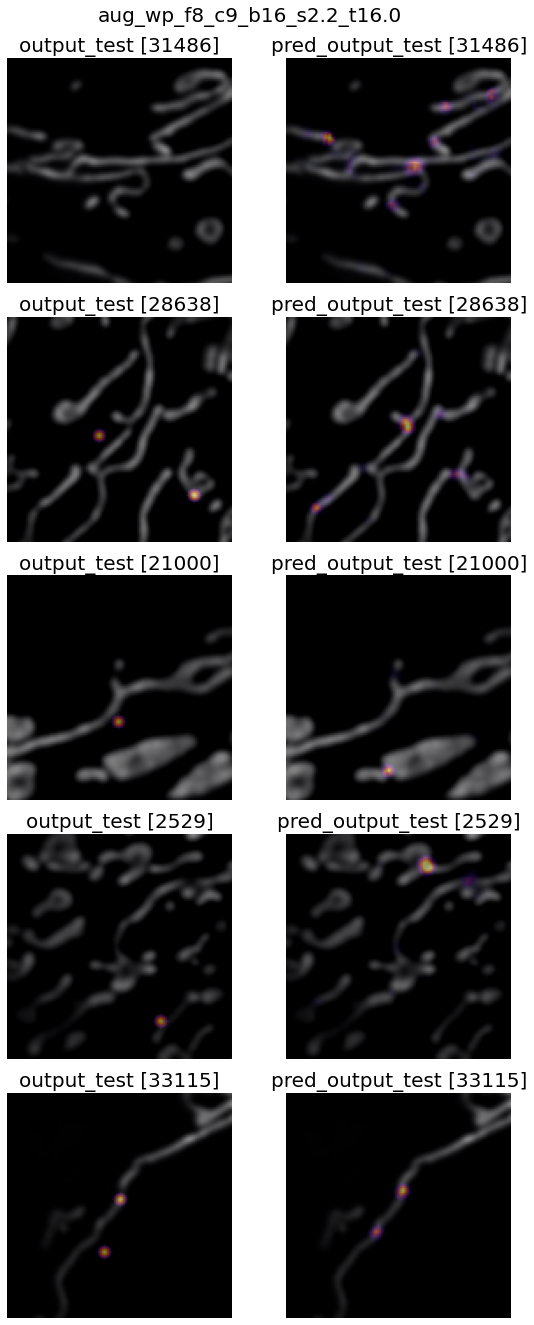

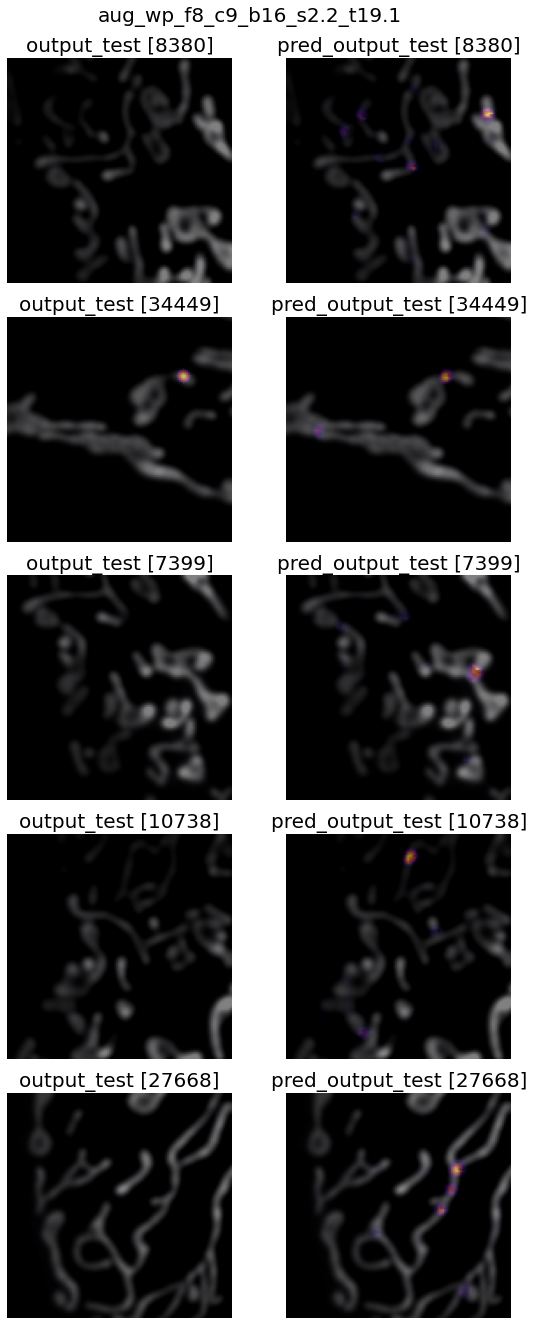

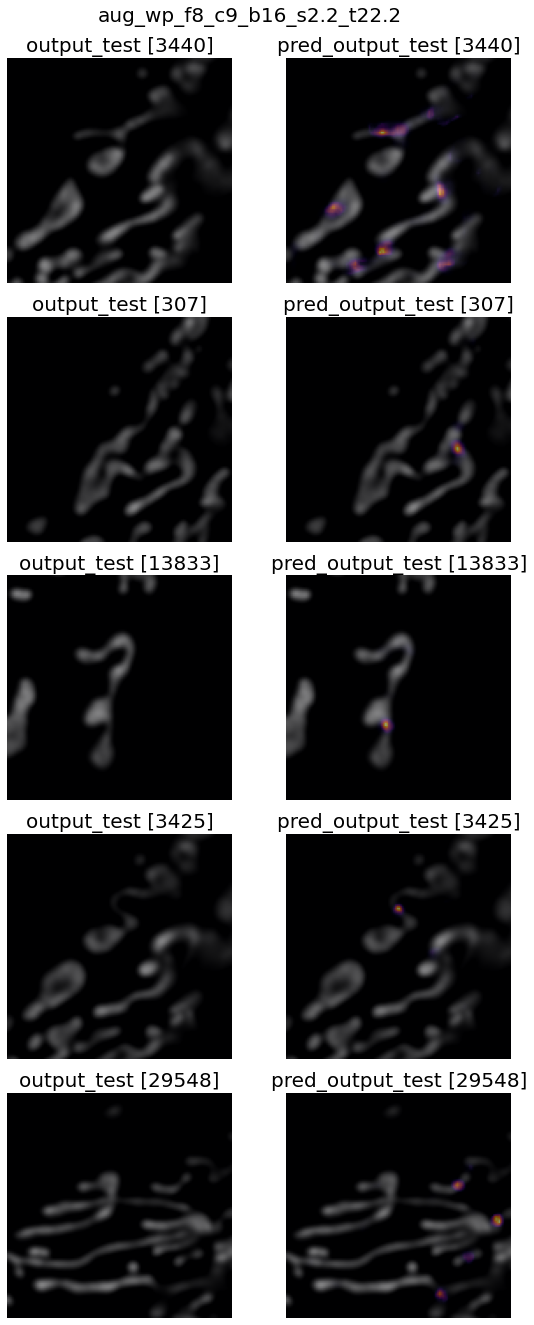

In [33]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

In [34]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/metrics
Done.


### All metrics

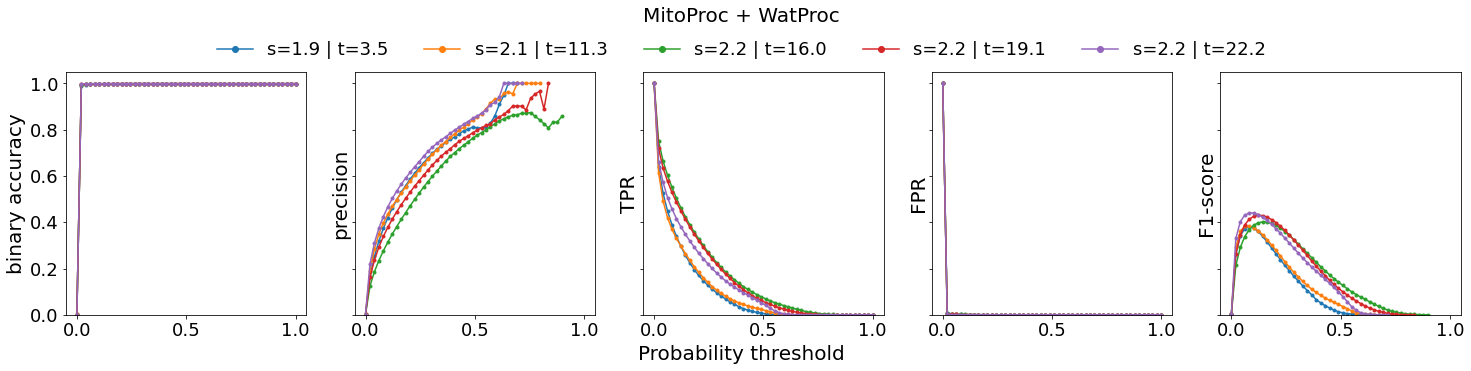

In [35]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f | t=%.1f'%(s, t) for s, t in zip(optimal_sigma, threshold)],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=5, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

### metricAtMaxF1

In [36]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][metrics[model_name]['F1-score']==np.nanmax(metrics[model_name]['F1-score'])][0]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

aug_wp_f8_c9_b16_s1.9_t3.5  aug_wp_f8_c9_b16_s2.1_t11.3  \
binary accuracy                    0.996588                     0.997967   
precision                          0.373165                     0.397087   
TPR                                0.388671                     0.369378   
FPR                                0.001767                     0.000959   
F1-score                           0.380761                     0.382731   

                 aug_wp_f8_c9_b16_s2.2_t16.0  aug_wp_f8_c9_b16_s2.2_t19.1  \
binary accuracy                     0.998464                     0.998786   
precision                           0.381189                     0.413427   
TPR                                 0.423768                     0.448559   
FPR                                 0.000837                     0.000651   
F1-score                            0.401352                     0.430277   

                 aug_wp_f8_c9_b16_s2.2_t22.2  
binary accuracy                     0.998997  
precision                           0.424626  
TPR                                 0.457337  
FPR                                 0.000535  
F1-score                            0.440375

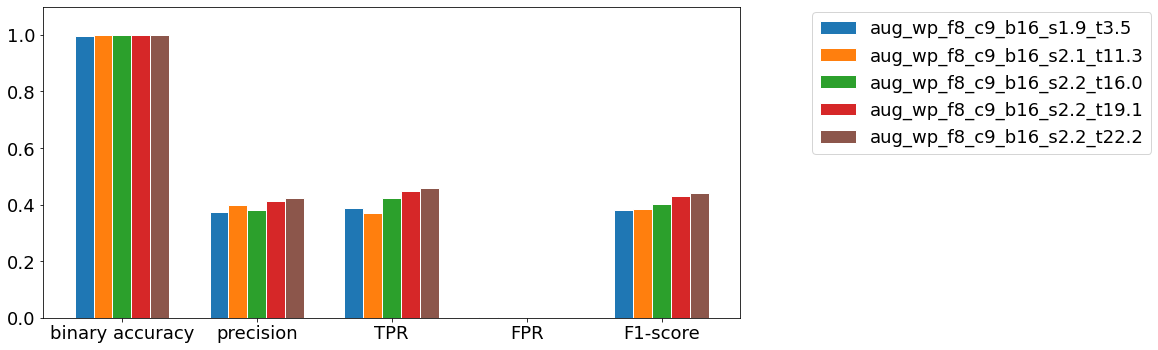

In [37]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'aug_wp_f8_c9_b16_s1.9_t3.5': 0.0021540626319679055, 'aug_wp_f8_c9_b16_s2.1_t11.3': 0.0013678225955447636, 'aug_wp_f8_c9_b16_s2.2_t16.0': 0.0009924068966427366, 'aug_wp_f8_c9_b16_s2.2_t19.1': 0.0008489660314611486, 'aug_wp_f8_c9_b16_s2.2_t22.2': 0.0007050220386402027}


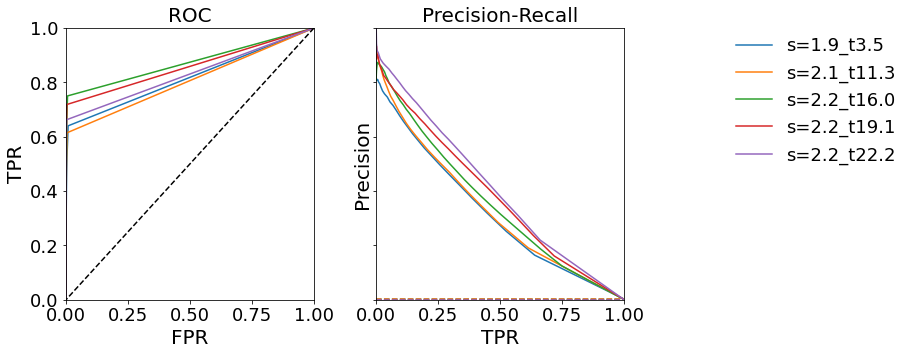

In [38]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

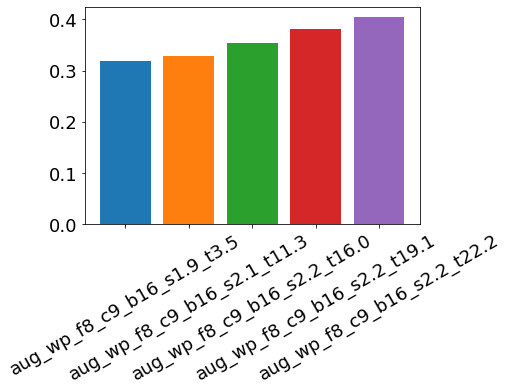

In [39]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

In [40]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats = fissionStats.T


Model name: aug_wp_f8_c9_b16_s1.9_t3.5


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 4396.30it/s]



Model name: aug_wp_f8_c9_b16_s2.1_t11.3


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 6025.60it/s]



Model name: aug_wp_f8_c9_b16_s2.2_t16.0


100%|████████████████████████████████████████████████████████| 7400/7400 [00:01<00:00, 7335.86it/s]



Model name: aug_wp_f8_c9_b16_s2.2_t19.1


100%|████████████████████████████████████████████████████████| 7400/7400 [00:00<00:00, 8260.41it/s]



Model name: aug_wp_f8_c9_b16_s2.2_t22.2


100%|████████████████████████████████████████████████████████| 7400/7400 [00:00<00:00, 9002.49it/s]


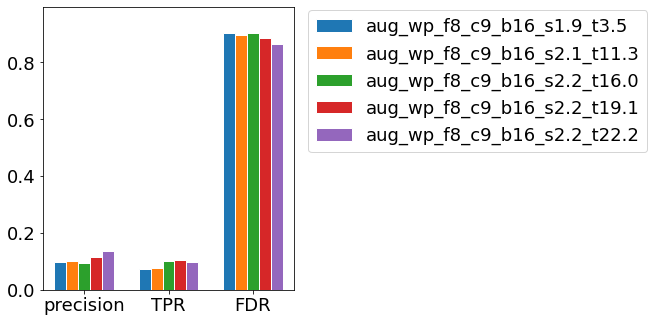

In [41]:
plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], color=colors)
plt.show()